In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from align import AlignDlib
from keras.models import model_from_json
from keras.models import load_model
from PIL import Image

Using TensorFlow backend.


In [2]:
#face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
ATTRS_NAME = "./data/lfw_attributes.txt"
IMAGES_NAME = "./data/lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "./data/lfw.tgz"

In [3]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
def fourier_transformation(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    rows, cols = img.shape
    crow, ccol = rows/2, cols/2
    fshift[int(crow-5):int(crow+5), int(ccol-5):int(ccol+5)] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

In [5]:
def load_dataset(path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    img_data_list=[]       
    input_img=cv2.imread(path)
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
    x,y,w,h = faces[0]
    face = input_img[y:y+h,x:x+w]
    print(face.shape)
    #face = fourier_transformation(face)
    face=cv2.resize(face,(96,96))
    img_data_list.append(face)
    img_data = np.stack(img_data_list).astype('uint8')
    print("New photo loaded")
    return img_data/ 255.0 - 0.5

In [6]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    #df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    #df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    #df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                #print(img.shape)
                #img = fourier_transformation(img)
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                foldername = os.path.split(m.name)
                filename = os.path.split(m.name)[-1]
                fname_splitted = filename[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img, "File": filename, "Path": foldername })

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')
    all_photos = all_photos.astype('float32') / 255.0 - 0.5

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids#all_attrs

In [7]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=96, dimy=96)

<TarInfo 'lfw' at 0x7fb65d0a6ae0>
<TarInfo 'lfw/George_HW_Bush' at 0x7fb65d0a6bb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7fb65d0a6a10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7fb65d0a6c80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7fb65d0a6d50>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7fb65d0a6ef0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7fb65d0a6e20>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7fb63e523120>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7fb63e5231f0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7fb63e5232c0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7fb63e523390>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7fb63e523460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7fb63e523530>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7fb63e523600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0018.jpg' at 0x7fb63e54e390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0019.jpg' at 0x7fb63e54e460>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0020.jpg' at 0x7fb63e54e530>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0021.jpg' at 0x7fb63e54e600>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0022.jpg' at 0x7fb63e54e6d0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0023.jpg' at 0x7fb63e54e7a0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0024.jpg' at 0x7fb63e54e870>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0025.jpg' at 0x7fb63e54e940>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0026.jpg' at 0x7fb63e54ea10>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0027.jpg' at 0x7fb63e54eae0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0028.jpg' at 0x7fb63e54ebb0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0029.jpg' at 0x7fb63e54ec80>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0010.jpg' at 0x7fb63e4faae0>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0011.jpg' at 0x7fb63e4fabb0>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0012.jpg' at 0x7fb63e4fac80>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0013.jpg' at 0x7fb63e4fad50>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0014.jpg' at 0x7fb63e4fae20>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0015.jpg' at 0x7fb63e4faef0>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0016.jpg' at 0x7fb63e4fa460>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0017.jpg' at 0x7fb63e4fe120>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0018.jpg' at 0x7fb63e4fe1f0>
<TarInfo 'lfw/Robert_Fico' at 0x7fb63e4fe2c0>
<TarInfo 'lfw/Robert_Fico/Robert_Fico_0001.jpg' at 0x7fb63e4fe390>
<TarInfo 'lfw/Robert_Fico/Robert_Fico_0002.jpg' at 0x7fb63e4fe050>
<TarInfo 'lfw/JK_Rowling' at 0x7fb63e4fe530>
<TarInfo 'lfw/JK_Rowling/JK_Rowling_0001.jpg' at 0x7fb63e4fe600>
<TarInfo 'lfw/JK_

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0160.jpg' at 0x7fb63e4a9c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0161.jpg' at 0x7fb63e4a9d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0162.jpg' at 0x7fb63e4a9e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0163.jpg' at 0x7fb63e4a9ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0164.jpg' at 0x7fb63e4a9120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0165.jpg' at 0x7fb63e4af050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0166.jpg' at 0x7fb63e4af1f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0167.jpg' at 0x7fb63e4af2c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0168.jpg' at 0x7fb63e4af390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0169.jpg' at 0x7fb63e4af460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0170.jpg' at 0x7fb63e4af530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0171.jpg' at 0x7fb63e4af600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0172.jpg' at 0x7fb63e4af6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0173.jpg' at 0x7fb63e4af7a0>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0356.jpg' at 0x7fb63e4591f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0357.jpg' at 0x7fb63e4592c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0358.jpg' at 0x7fb63e459390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0359.jpg' at 0x7fb63e459460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0360.jpg' at 0x7fb63e459530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0361.jpg' at 0x7fb63e459600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0362.jpg' at 0x7fb63e4596d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0363.jpg' at 0x7fb63e4597a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0364.jpg' at 0x7fb63e459870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0365.jpg' at 0x7fb63e459940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0366.jpg' at 0x7fb63e459a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0367.jpg' at 0x7fb63e459ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0368.jpg' at 0x7fb63e459bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0369.jpg' at 0x7fb63e459c80>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0529.jpg' at 0x7fb63e480390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0530.jpg' at 0x7fb63e480460>
<TarInfo 'lfw/Ciro_Gomes' at 0x7fb63e480530>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0001.jpg' at 0x7fb63e480600>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0002.jpg' at 0x7fb63e480050>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0003.jpg' at 0x7fb63e4807a0>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0004.jpg' at 0x7fb63e480870>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0005.jpg' at 0x7fb63e480940>
<TarInfo 'lfw/Sergio_Garcia' at 0x7fb63e480a10>
<TarInfo 'lfw/Sergio_Garcia/Sergio_Garcia_0001.jpg' at 0x7fb63e480ae0>
<TarInfo 'lfw/Sergio_Garcia/Sergio_Garcia_0002.jpg' at 0x7fb63e4806d0>
<TarInfo 'lfw/Diego_Armando_Maradona' at 0x7fb63e480c80>
<TarInfo 'lfw/Diego_Armando_Maradona/Diego_Armando_Maradona_0001.jpg' at 0x7fb63e480d50>
<TarInfo 'lfw/Hassan_Nasrallah' at 0x7fb63e480bb0>
<TarInfo 'lfw/Hassan_Nasrallah/Hassan_Nasrallah_0001.jpg' at 0x7fb63e480ef0>
<TarInfo 'lfw/Hassan_Nas

<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0092.jpg' at 0x7fb63e4342c0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0093.jpg' at 0x7fb63e434390>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0094.jpg' at 0x7fb63e434460>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0095.jpg' at 0x7fb63e434530>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0096.jpg' at 0x7fb63e434600>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0097.jpg' at 0x7fb63e4346d0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0098.jpg' at 0x7fb63e4347a0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0099.jpg' at 0x7fb63e434870>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0100.jpg' at 0x7fb63e434940>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0101.jpg' at 0x7fb63e434a10>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0102.jpg' at 0x7fb63e434ae0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0103.jpg' at 0x7fb63e434bb0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0104.jpg' at 0x7fb63e434c80>
<TarInfo 'lfw/Donald_Rums

<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0025.jpg' at 0x7fb63e3e72c0>
<TarInfo 'lfw/Judi_Patton' at 0x7fb63e3e7390>
<TarInfo 'lfw/Judi_Patton/Judi_Patton_0001.jpg' at 0x7fb63e3e7460>
<TarInfo 'lfw/Viktor_Yushchenko' at 0x7fb63e3e7050>
<TarInfo 'lfw/Viktor_Yushchenko/Viktor_Yushchenko_0001.jpg' at 0x7fb63e3e7600>
<TarInfo 'lfw/William_Harrison' at 0x7fb63e3e7530>
<TarInfo 'lfw/William_Harrison/William_Harrison_0001.jpg' at 0x7fb63e3e77a0>
<TarInfo 'lfw/Jorge_Moreno' at 0x7fb63e3e76d0>
<TarInfo 'lfw/Jorge_Moreno/Jorge_Moreno_0001.jpg' at 0x7fb63e3e7940>
<TarInfo 'lfw/Wayne_Brady' at 0x7fb63e3e7870>
<TarInfo 'lfw/Wayne_Brady/Wayne_Brady_0001.jpg' at 0x7fb63e3e7ae0>
<TarInfo 'lfw/William_Hochul' at 0x7fb63e3e7a10>
<TarInfo 'lfw/William_Hochul/William_Hochul_0001.jpg' at 0x7fb63e3e7c80>
<TarInfo 'lfw/William_Hochul/William_Hochul_0002.jpg' at 0x7fb63e3e7bb0>
<TarInfo 'lfw/Maurice_Papon' at 0x7fb63e3e7e20>
<TarInfo 'lfw/Maurice_Papon/Maurice_Papon_0001.jpg' at 0x7fb63e3e7ef0>
<TarInfo 'lfw/Shim

<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0020.jpg' at 0x7fb63e39b390>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0021.jpg' at 0x7fb63e39b460>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0022.jpg' at 0x7fb63e39b530>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0023.jpg' at 0x7fb63e39b600>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0024.jpg' at 0x7fb63e39b6d0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0025.jpg' at 0x7fb63e39b7a0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0026.jpg' at 0x7fb63e39b870>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0027.jpg' at 0x7fb63e39b940>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0028.jpg' at 0x7fb63e39ba10>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0029.jpg' at 0x7fb63e39bae0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0030.jpg' at 0x7fb63e39bbb0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0031.jpg' at 0x7fb63e39bc80>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0032.jpg' at 0x7fb63e39bd50>
<TarInfo 'lfw/Mireya_Elisa_Moscoso_Rodriguez' at 0x7fb63e39be20>
<TarInfo 'lfw/Mireya_Elisa_Moscoso_Rodriguez/Mireya_Elisa_Moscoso_Rodriguez_0001.jpg' at 0

<TarInfo 'lfw/Tony_Blair/Tony_Blair_0049.jpg' at 0x7fb63e3c96d0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0050.jpg' at 0x7fb63e3c97a0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0051.jpg' at 0x7fb63e3c9870>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0052.jpg' at 0x7fb63e3c9940>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0053.jpg' at 0x7fb63e3c9a10>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0054.jpg' at 0x7fb63e3c9ae0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0055.jpg' at 0x7fb63e3c9bb0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0056.jpg' at 0x7fb63e3c9c80>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0057.jpg' at 0x7fb63e3c9d50>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0058.jpg' at 0x7fb63e3c9e20>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0059.jpg' at 0x7fb63e3c9ef0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0060.jpg' at 0x7fb63e3c9050>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0061.jpg' at 0x7fb63e3cf120>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0062.jpg' at 0x7fb63e3cf1f0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0063.jpg' at 0x7fb63e3cf2c0>
<TarInfo 'lfw/Tony_Blair/

<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0002.jpg' at 0x7fb63e37e050>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0003.jpg' at 0x7fb63e37e530>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0004.jpg' at 0x7fb63e37e600>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0005.jpg' at 0x7fb63e37e6d0>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0006.jpg' at 0x7fb63e37e7a0>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0007.jpg' at 0x7fb63e37e870>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0008.jpg' at 0x7fb63e37e940>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0009.jpg' at 0x7fb63e37ea10>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0010.jpg' at 0x7fb63e37eae0>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0011.jpg' at 0x7fb63e37ebb0>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0012.jpg' at 0x7fb63e37ec80>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0013.jpg' at 0x7fb63e37ed50>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0014.jpg' at 0x7fb63e37ee20>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0015.jpg' at 0x7fb63e37eef0>
<TarInfo 'lfw/Vicente_Fox/Vicente_Fox_0016.jpg' at 0x7fb63e37e

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0074.jpg' at 0x7fb63e32d460>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0075.jpg' at 0x7fb63e32d530>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0076.jpg' at 0x7fb63e32d600>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0077.jpg' at 0x7fb63e32d6d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0078.jpg' at 0x7fb63e32d7a0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0079.jpg' at 0x7fb63e32d870>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0080.jpg' at 0x7fb63e32d940>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0081.jpg' at 0x7fb63e32da10>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0082.jpg' at 0x7fb63e32dae0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0083.jpg' at 0x7fb63e32dbb0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0084.jpg' at 0x7fb63e32dc80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0085.jpg' at 0x7fb63e32dd50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0086.jpg' at 0x7fb63e32de20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0087.jpg' at 0x7fb63e32def0>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Laura_Bush/Laura_Bush_0004.jpg' at 0x7fb63e2d5120>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0005.jpg' at 0x7fb63e2d51f0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0006.jpg' at 0x7fb63e2d52c0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0007.jpg' at 0x7fb63e2d5390>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0008.jpg' at 0x7fb63e2d5460>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0009.jpg' at 0x7fb63e2d5530>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0010.jpg' at 0x7fb63e2d5600>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0011.jpg' at 0x7fb63e2d56d0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0012.jpg' at 0x7fb63e2d57a0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0013.jpg' at 0x7fb63e2d5870>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0014.jpg' at 0x7fb63e2d5940>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0015.jpg' at 0x7fb63e2d5a10>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0016.jpg' at 0x7fb63e2d5ae0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0017.jpg' at 0x7fb63e2d5bb0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0018.jpg' at 0x7fb63e2d5c80>
<TarInfo 'lfw/Laura_Bush/

<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0017.jpg' at 0x7fb63e2ffe20>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0018.jpg' at 0x7fb63e2ffef0>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0019.jpg' at 0x7fb63e2ff1f0>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0020.jpg' at 0x7fb63e303120>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0021.jpg' at 0x7fb63e3031f0>
<TarInfo 'lfw/Serena_Williams' at 0x7fb63e3032c0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0001.jpg' at 0x7fb63e303390>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0002.jpg' at 0x7fb63e303050>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0003.jpg' at 0x7fb63e303530>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0004.jpg' at 0x7fb63e303600>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0005.jpg' at 0x7fb63e3036d0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0006.jpg' at 0x7fb63e3037a0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0007.jpg' at 0x7fb63e303870>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0008

<TarInfo 'lfw/Justin_Leonard/Justin_Leonard_0003.jpg' at 0x7fb63e2b2c80>
<TarInfo 'lfw/Justin_Leonard/Justin_Leonard_0004.jpg' at 0x7fb63e2b2d50>
<TarInfo 'lfw/Tatiana_Gratcheva' at 0x7fb63e2b2e20>
<TarInfo 'lfw/Tatiana_Gratcheva/Tatiana_Gratcheva_0001.jpg' at 0x7fb63e2b2ef0>
<TarInfo 'lfw/Garry_Kasparov' at 0x7fb63e2b2bb0>
<TarInfo 'lfw/Garry_Kasparov/Garry_Kasparov_0001.jpg' at 0x7fb63e2b7120>
<TarInfo 'lfw/Garry_Kasparov/Garry_Kasparov_0002.jpg' at 0x7fb63e2b7050>
<TarInfo 'lfw/Andrei_Konchalovsky' at 0x7fb63e2b72c0>
<TarInfo 'lfw/Andrei_Konchalovsky/Andrei_Konchalovsky_0001.jpg' at 0x7fb63e2b7390>
<TarInfo 'lfw/Juljia_Vysotskij' at 0x7fb63e2b71f0>
<TarInfo 'lfw/Juljia_Vysotskij/Juljia_Vysotskij_0001.jpg' at 0x7fb63e2b7530>
<TarInfo 'lfw/Condoleezza_Rice' at 0x7fb63e2b7460>
<TarInfo 'lfw/Condoleezza_Rice/Condoleezza_Rice_0001.jpg' at 0x7fb63e2b76d0>
<TarInfo 'lfw/Condoleezza_Rice/Condoleezza_Rice_0002.jpg' at 0x7fb63e2b7600>
<TarInfo 'lfw/Condoleezza_Rice/Condoleezza_Rice_0003.jpg' 

<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0006.jpg' at 0x7fb63e266ef0>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0007.jpg' at 0x7fb63e266bb0>
<TarInfo 'lfw/Horace_Newcomb' at 0x7fb63e26a120>
<TarInfo 'lfw/Horace_Newcomb/Horace_Newcomb_0001.jpg' at 0x7fb63e26a1f0>
<TarInfo 'lfw/Priscilla_Presley' at 0x7fb63e26a050>
<TarInfo 'lfw/Priscilla_Presley/Priscilla_Presley_0001.jpg' at 0x7fb63e26a390>
<TarInfo 'lfw/Priscilla_Presley/Priscilla_Presley_0002.jpg' at 0x7fb63e26a2c0>
<TarInfo 'lfw/Penelope_Cruz' at 0x7fb63e26a530>
<TarInfo 'lfw/Penelope_Cruz/Penelope_Cruz_0001.jpg' at 0x7fb63e26a600>
<TarInfo 'lfw/Penelope_Cruz/Penelope_Cruz_0002.jpg' at 0x7fb63e26a460>
<TarInfo 'lfw/Penelope_Cruz/Penelope_Cruz_0003.jpg' at 0x7fb63e26a7a0>
<TarInfo 'lfw/Karen_Lynn_Gorney' at 0x7fb63e26a870>
<TarInfo 'lfw/Karen_Lynn_Gorney/Karen_Lynn_Gorney_0001.jpg' at 0x7fb63e26a940>
<TarInfo 'lfw/Mike_Webster' at 0x7fb63e26a6d0>
<TarInfo 'lfw/Mike_Webster/Mike_Webster_0001.jpg' at 0x7fb6

<TarInfo 'lfw/Fran_Drescher' at 0x7fb63e21d6d0>
<TarInfo 'lfw/Fran_Drescher/Fran_Drescher_0001.jpg' at 0x7fb63e21d7a0>
<TarInfo 'lfw/Fran_Drescher/Fran_Drescher_0002.jpg' at 0x7fb63e21d600>
<TarInfo 'lfw/Ali_Naimi' at 0x7fb63e21d940>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0001.jpg' at 0x7fb63e21da10>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0002.jpg' at 0x7fb63e21d870>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0003.jpg' at 0x7fb63e21dbb0>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0004.jpg' at 0x7fb63e21dc80>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0005.jpg' at 0x7fb63e21dd50>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0006.jpg' at 0x7fb63e21de20>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0007.jpg' at 0x7fb63e21def0>
<TarInfo 'lfw/Ali_Naimi/Ali_Naimi_0008.jpg' at 0x7fb63e21dae0>
<TarInfo 'lfw/Carla_Moreno' at 0x7fb63e221120>
<TarInfo 'lfw/Carla_Moreno/Carla_Moreno_0001.jpg' at 0x7fb63e2211f0>
<TarInfo 'lfw/Sheila_Taormina' at 0x7fb63e221050>
<TarInfo 'lfw/Sheila_Taormina/Sheila_Taormina_0001.jpg' at 0x7fb63e221390>
<TarInfo 'lfw/Harald_

<TarInfo 'lfw/Steffi_Graf/Steffi_Graf_0003.jpg' at 0x7fb63e1d5600>
<TarInfo 'lfw/Steffi_Graf/Steffi_Graf_0004.jpg' at 0x7fb63e1d56d0>
<TarInfo 'lfw/Steffi_Graf/Steffi_Graf_0005.jpg' at 0x7fb63e1d57a0>
<TarInfo 'lfw/Johnny_Tapia' at 0x7fb63e1d5870>
<TarInfo 'lfw/Johnny_Tapia/Johnny_Tapia_0001.jpg' at 0x7fb63e1d5940>
<TarInfo 'lfw/Johnny_Tapia/Johnny_Tapia_0002.jpg' at 0x7fb63e1d5530>
<TarInfo 'lfw/Johnny_Tapia/Johnny_Tapia_0003.jpg' at 0x7fb63e1d5ae0>
<TarInfo 'lfw/Danny_Avalon' at 0x7fb63e1d5bb0>
<TarInfo 'lfw/Danny_Avalon/Danny_Avalon_0001.jpg' at 0x7fb63e1d5c80>
<TarInfo 'lfw/Richard_Gephardt' at 0x7fb63e1d5a10>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0001.jpg' at 0x7fb63e1d5e20>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0002.jpg' at 0x7fb63e1d5d50>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0003.jpg' at 0x7fb63e1d5ef0>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0004.jpg' at 0x7fb63e1d8050>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0005.jpg' at 0x7fb63e1

<TarInfo 'lfw/Liam_Neeson' at 0x7fb63e204ef0>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0001.jpg' at 0x7fb63e208050>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0002.jpg' at 0x7fb63e208120>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0003.jpg' at 0x7fb63e2082c0>
<TarInfo 'lfw/Kathryn_Bigelow' at 0x7fb63e208390>
<TarInfo 'lfw/Kathryn_Bigelow/Kathryn_Bigelow_0001.jpg' at 0x7fb63e208460>
<TarInfo 'lfw/Kathryn_Bigelow/Kathryn_Bigelow_0002.jpg' at 0x7fb63e2081f0>
<TarInfo 'lfw/Alessandro_Nesta' at 0x7fb63e208600>
<TarInfo 'lfw/Alessandro_Nesta/Alessandro_Nesta_0001.jpg' at 0x7fb63e2086d0>
<TarInfo 'lfw/Dino_Risi' at 0x7fb63e208530>
<TarInfo 'lfw/Dino_Risi/Dino_Risi_0001.jpg' at 0x7fb63e208870>
<TarInfo 'lfw/Daniela_Hantuchova' at 0x7fb63e2087a0>
<TarInfo 'lfw/Daniela_Hantuchova/Daniela_Hantuchova_0001.jpg' at 0x7fb63e208a10>
<TarInfo 'lfw/Daniela_Hantuchova/Daniela_Hantuchova_0002.jpg' at 0x7fb63e208940>
<TarInfo 'lfw/Allison_Searing' at 0x7fb63e208bb0>
<TarInfo 'lfw/Allison_Searing/Allison_Searing_0001.jp

<TarInfo 'lfw/Jack_Straw/Jack_Straw_0015.jpg' at 0x7fb63e1b7530>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0016.jpg' at 0x7fb63e1bb120>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0017.jpg' at 0x7fb63e1bb1f0>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0018.jpg' at 0x7fb63e1bb2c0>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0019.jpg' at 0x7fb63e1bb390>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0020.jpg' at 0x7fb63e1bb460>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0021.jpg' at 0x7fb63e1bb530>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0022.jpg' at 0x7fb63e1bb600>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0023.jpg' at 0x7fb63e1bb6d0>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0024.jpg' at 0x7fb63e1bb7a0>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0025.jpg' at 0x7fb63e1bb870>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0026.jpg' at 0x7fb63e1bb940>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0027.jpg' at 0x7fb63e1bba10>
<TarInfo 'lfw/Jack_Straw/Jack_Straw_0028.jpg' at 0x7fb63e1bbae0>
<TarInfo 'lfw/Pernilla_Bjorn' at 0x7fb63e1bbbb0>
<TarInfo 'lfw/Pernilla_Bjorn/Pernilla_Bjo

<TarInfo 'lfw/Michael_Chiklis' at 0x7fb63e170600>
<TarInfo 'lfw/Michael_Chiklis/Michael_Chiklis_0001.jpg' at 0x7fb63e1706d0>
<TarInfo 'lfw/Michael_Chiklis/Michael_Chiklis_0002.jpg' at 0x7fb63e170050>
<TarInfo 'lfw/Michael_Chiklis/Michael_Chiklis_0003.jpg' at 0x7fb63e170870>
<TarInfo 'lfw/Michael_Chiklis/Michael_Chiklis_0004.jpg' at 0x7fb63e170940>
<TarInfo 'lfw/Michael_Chiklis/Michael_Chiklis_0005.jpg' at 0x7fb63e170a10>
<TarInfo 'lfw/Carson_Daly' at 0x7fb63e170ae0>
<TarInfo 'lfw/Carson_Daly/Carson_Daly_0001.jpg' at 0x7fb63e170bb0>
<TarInfo 'lfw/Carson_Daly/Carson_Daly_0002.jpg' at 0x7fb63e1707a0>
<TarInfo 'lfw/Michael_Patrick_King' at 0x7fb63e170d50>
<TarInfo 'lfw/Michael_Patrick_King/Michael_Patrick_King_0001.jpg' at 0x7fb63e170e20>
<TarInfo 'lfw/Michael_Patrick_King/Michael_Patrick_King_0002.jpg' at 0x7fb63e170c80>
<TarInfo 'lfw/Jay_Leno' at 0x7fb63e170ef0>
<TarInfo 'lfw/Jay_Leno/Jay_Leno_0001.jpg' at 0x7fb63e173120>
<TarInfo 'lfw/Jay_Leno/Jay_Leno_0002.jpg' at 0x7fb63e173050>
<TarI

<TarInfo 'lfw/Ahmed_Qureia' at 0x7fb63e12f460>
<TarInfo 'lfw/Ahmed_Qureia/Ahmed_Qureia_0001.jpg' at 0x7fb63e12f530>
<TarInfo 'lfw/Wan_Yanhai' at 0x7fb63e12f050>
<TarInfo 'lfw/Wan_Yanhai/Wan_Yanhai_0001.jpg' at 0x7fb63e12f6d0>
<TarInfo 'lfw/Nicole_Kidman' at 0x7fb63e12f600>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0001.jpg' at 0x7fb63e12f870>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0002.jpg' at 0x7fb63e12f7a0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0003.jpg' at 0x7fb63e12fa10>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0004.jpg' at 0x7fb63e12fae0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0005.jpg' at 0x7fb63e12fbb0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0006.jpg' at 0x7fb63e12fc80>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0007.jpg' at 0x7fb63e12fd50>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0008.jpg' at 0x7fb63e12fe20>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0009.jpg' at 0x7fb63e12fef0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0010.jpg' at 0x7fb63e12f940>
<TarInfo 'lfw/Ni

<TarInfo 'lfw/Gian_Marco' at 0x7fb63e0e6120>
<TarInfo 'lfw/Gian_Marco/Gian_Marco_0001.jpg' at 0x7fb63e0e6390>
<TarInfo 'lfw/Gian_Marco/Gian_Marco_0002.jpg' at 0x7fb63e0e62c0>
<TarInfo 'lfw/Gian_Marco/Gian_Marco_0003.jpg' at 0x7fb63e0e6530>
<TarInfo 'lfw/Jean_Nagel' at 0x7fb63e0e6600>
<TarInfo 'lfw/Jean_Nagel/Jean_Nagel_0001.jpg' at 0x7fb63e0e66d0>
<TarInfo 'lfw/Al_Gore' at 0x7fb63e0e6460>
<TarInfo 'lfw/Al_Gore/Al_Gore_0001.jpg' at 0x7fb63e0e6870>
<TarInfo 'lfw/Al_Gore/Al_Gore_0002.jpg' at 0x7fb63e0e67a0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0003.jpg' at 0x7fb63e0e6a10>
<TarInfo 'lfw/Al_Gore/Al_Gore_0004.jpg' at 0x7fb63e0e6ae0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0005.jpg' at 0x7fb63e0e6bb0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0006.jpg' at 0x7fb63e0e6c80>
<TarInfo 'lfw/Al_Gore/Al_Gore_0007.jpg' at 0x7fb63e0e6d50>
<TarInfo 'lfw/Al_Gore/Al_Gore_0008.jpg' at 0x7fb63e0e6940>
<TarInfo 'lfw/James_Franco' at 0x7fb63e0e6ef0>
<TarInfo 'lfw/James_Franco/James_Franco_0001.jpg' at 0x7fb63e0e6e20>
<TarInfo 'lfw/James_

<TarInfo 'lfw/Patricia_Clarkson' at 0x7fb63e09ebb0>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0001.jpg' at 0x7fb63e09ee20>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0002.jpg' at 0x7fb63e09ed50>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0003.jpg' at 0x7fb63e09eef0>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0004.jpg' at 0x7fb63e0a2050>
<TarInfo 'lfw/Mark_Foley' at 0x7fb63e0a21f0>
<TarInfo 'lfw/Mark_Foley/Mark_Foley_0001.jpg' at 0x7fb63e0a22c0>
<TarInfo 'lfw/Tom_Brady' at 0x7fb63e0a2120>
<TarInfo 'lfw/Tom_Brady/Tom_Brady_0001.jpg' at 0x7fb63e0a2460>
<TarInfo 'lfw/Tom_Brady/Tom_Brady_0002.jpg' at 0x7fb63e0a2390>
<TarInfo 'lfw/Jan_Bjoerklund' at 0x7fb63e0a2600>
<TarInfo 'lfw/Jan_Bjoerklund/Jan_Bjoerklund_0001.jpg' at 0x7fb63e0a26d0>
<TarInfo 'lfw/Karin_Pilsaeter' at 0x7fb63e0a2530>
<TarInfo 'lfw/Karin_Pilsaeter/Karin_Pilsaeter_0001.jpg' at 0x7fb63e0a2870>
<TarInfo 'lfw/Kevin_Sorbo' at 0x7fb63e0a27a0>
<TarInfo 'lfw/Kevin_Sorbo/Kevin_Sorbo_0001.jpg' at 0x7fb63e

<TarInfo 'lfw/Wolfgang_Schuessel/Wolfgang_Schuessel_0003.jpg' at 0x7fb63e05fef0>
<TarInfo 'lfw/Wolfgang_Schuessel/Wolfgang_Schuessel_0004.jpg' at 0x7fb63e05fe20>
<TarInfo 'lfw/Martha_Stewart' at 0x7fb63e062120>
<TarInfo 'lfw/Martha_Stewart/Martha_Stewart_0001.jpg' at 0x7fb63e0621f0>
<TarInfo 'lfw/Martha_Stewart/Martha_Stewart_0002.jpg' at 0x7fb63e062050>
<TarInfo 'lfw/Martha_Stewart/Martha_Stewart_0003.jpg' at 0x7fb63e062390>
<TarInfo 'lfw/Martha_Stewart/Martha_Stewart_0004.jpg' at 0x7fb63e062460>
<TarInfo 'lfw/Martha_Stewart/Martha_Stewart_0005.jpg' at 0x7fb63e062530>
<TarInfo 'lfw/Nate_Hybl' at 0x7fb63e062600>
<TarInfo 'lfw/Nate_Hybl/Nate_Hybl_0001.jpg' at 0x7fb63e0626d0>
<TarInfo 'lfw/Marco_Irizarry' at 0x7fb63e0622c0>
<TarInfo 'lfw/Marco_Irizarry/Marco_Irizarry_0001.jpg' at 0x7fb63e062870>
<TarInfo 'lfw/Vaclav_Havel' at 0x7fb63e0627a0>
<TarInfo 'lfw/Vaclav_Havel/Vaclav_Havel_0001.jpg' at 0x7fb63e062a10>
<TarInfo 'lfw/Vaclav_Havel/Vaclav_Havel_0002.jpg' at 0x7fb63e062940>
<TarInfo '

<TarInfo 'lfw/Erin_Runnion/Erin_Runnion_0004.jpg' at 0x7fb63e01de20>
<TarInfo 'lfw/Dave_Matthews' at 0x7fb63e01def0>
<TarInfo 'lfw/Dave_Matthews/Dave_Matthews_0001.jpg' at 0x7fb63e01dc80>
<TarInfo 'lfw/Greg_Hodge' at 0x7fb63e022050>
<TarInfo 'lfw/Greg_Hodge/Greg_Hodge_0001.jpg' at 0x7fb63e0221f0>
<TarInfo 'lfw/Ian_Thorpe' at 0x7fb63e022120>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0001.jpg' at 0x7fb63e022390>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0002.jpg' at 0x7fb63e0222c0>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0003.jpg' at 0x7fb63e022530>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0004.jpg' at 0x7fb63e022600>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0005.jpg' at 0x7fb63e0226d0>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0006.jpg' at 0x7fb63e0227a0>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0007.jpg' at 0x7fb63e022870>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0008.jpg' at 0x7fb63e022940>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0009.jpg' at 0x7fb63e022a10>
<TarInfo 'lfw/Ian_Thorpe/Ian_Thorpe_0010.jpg' at 0x7fb63e022ae0>
<TarInf

<TarInfo 'lfw/King_Abdullah_II/King_Abdullah_II_0002.jpg' at 0x7fb63dfd5e20>
<TarInfo 'lfw/King_Abdullah_II/King_Abdullah_II_0003.jpg' at 0x7fb63dfd9120>
<TarInfo 'lfw/King_Abdullah_II/King_Abdullah_II_0004.jpg' at 0x7fb63dfd91f0>
<TarInfo 'lfw/King_Abdullah_II/King_Abdullah_II_0005.jpg' at 0x7fb63dfd92c0>
<TarInfo 'lfw/Bobby_Bowden' at 0x7fb63dfd9390>
<TarInfo 'lfw/Bobby_Bowden/Bobby_Bowden_0001.jpg' at 0x7fb63dfd9460>
<TarInfo 'lfw/Kathleen_Kennedy_Townsend' at 0x7fb63dfd9050>
<TarInfo 'lfw/Kathleen_Kennedy_Townsend/Kathleen_Kennedy_Townsend_0001.jpg' at 0x7fb63dfd9600>
<TarInfo 'lfw/Kathleen_Kennedy_Townsend/Kathleen_Kennedy_Townsend_0002.jpg' at 0x7fb63dfd9530>
<TarInfo 'lfw/Kathleen_Kennedy_Townsend/Kathleen_Kennedy_Townsend_0003.jpg' at 0x7fb63dfd97a0>
<TarInfo 'lfw/Kathleen_Kennedy_Townsend/Kathleen_Kennedy_Townsend_0004.jpg' at 0x7fb63dfd9870>
<TarInfo 'lfw/Yasser_Arafat' at 0x7fb63dfd9940>
<TarInfo 'lfw/Yasser_Arafat/Yasser_Arafat_0001.jpg' at 0x7fb63dfd9a10>
<TarInfo 'lfw/Yas

<TarInfo 'lfw/Willis_Roberts' at 0x7fb63df95ae0>
<TarInfo 'lfw/Willis_Roberts/Willis_Roberts_0001.jpg' at 0x7fb63df95bb0>
<TarInfo 'lfw/Dario_Franchitti' at 0x7fb63df95a10>
<TarInfo 'lfw/Dario_Franchitti/Dario_Franchitti_0001.jpg' at 0x7fb63df95d50>
<TarInfo 'lfw/Javier_Solana' at 0x7fb63df95c80>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0001.jpg' at 0x7fb63df95ef0>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0002.jpg' at 0x7fb63df95e20>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0003.jpg' at 0x7fb63df99050>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0004.jpg' at 0x7fb63df991f0>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0005.jpg' at 0x7fb63df992c0>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0006.jpg' at 0x7fb63df99390>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0007.jpg' at 0x7fb63df99460>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0008.jpg' at 0x7fb63df99530>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0009.jpg' at 0x7fb63df99600>
<TarInfo 'lfw/Javier_Solana/Javier_Solana_0010.jpg' at 0x7fb63d

<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0002.jpg' at 0x7fb63df551f0>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0003.jpg' at 0x7fb63df55460>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0004.jpg' at 0x7fb63df55530>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0005.jpg' at 0x7fb63df55600>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0006.jpg' at 0x7fb63df556d0>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0007.jpg' at 0x7fb63df557a0>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0008.jpg' at 0x7fb63df55870>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0009.jpg' at 0x7fb63df55940>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0010.jpg' at 0x7fb63df55a10>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0011.jpg' at 0x7fb63df55ae0>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0012.jpg' at 0x7fb63df55bb0>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0013.jpg' at 0x7fb63df55c80>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_00

<TarInfo 'lfw/Martin_McGuinness/Martin_McGuinness_0003.jpg' at 0x7fb63df8dae0>
<TarInfo 'lfw/Martin_McGuinness/Martin_McGuinness_0004.jpg' at 0x7fb63df8dbb0>
<TarInfo 'lfw/Martin_McGuinness/Martin_McGuinness_0005.jpg' at 0x7fb63df8dc80>
<TarInfo 'lfw/Qazi_Afzal' at 0x7fb63df8dd50>
<TarInfo 'lfw/Qazi_Afzal/Qazi_Afzal_0001.jpg' at 0x7fb63df8de20>
<TarInfo 'lfw/Kim_Chinn' at 0x7fb63df8da10>
<TarInfo 'lfw/Kim_Chinn/Kim_Chinn_0001.jpg' at 0x7fb63df8def0>
<TarInfo 'lfw/Queen_Elizabeth_II' at 0x7fb63df91050>
<TarInfo 'lfw/Queen_Elizabeth_II/Queen_Elizabeth_II_0001.jpg' at 0x7fb63df911f0>
<TarInfo 'lfw/Queen_Elizabeth_II/Queen_Elizabeth_II_0002.jpg' at 0x7fb63df91120>
<TarInfo 'lfw/Queen_Elizabeth_II/Queen_Elizabeth_II_0003.jpg' at 0x7fb63df91390>
<TarInfo 'lfw/Queen_Elizabeth_II/Queen_Elizabeth_II_0004.jpg' at 0x7fb63df91460>
<TarInfo 'lfw/Queen_Elizabeth_II/Queen_Elizabeth_II_0005.jpg' at 0x7fb63df91530>
<TarInfo 'lfw/Queen_Elizabeth_II/Queen_Elizabeth_II_0006.jpg' at 0x7fb63df91600>
<TarInf

<TarInfo 'lfw/Jeremy_Greenstock' at 0x7fb63df3d940>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0001.jpg' at 0x7fb63df3da10>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0002.jpg' at 0x7fb63df3d7a0>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0003.jpg' at 0x7fb63df3dbb0>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0004.jpg' at 0x7fb63df3dc80>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0005.jpg' at 0x7fb63df3dd50>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0006.jpg' at 0x7fb63df3de20>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0007.jpg' at 0x7fb63df3def0>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0008.jpg' at 0x7fb63df3dae0>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0009.jpg' at 0x7fb63df41050>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0010.jpg' at 0x7fb63df411f0>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0011.jpg' at 0x7fb63df412c0>
<TarInfo 'lfw/Jeremy_Greenstock/Jeremy_Greenstock_0012.jpg' at 0x7fb63df41390>


<TarInfo 'lfw/Bruce_Gebhardt' at 0x7fb63def57a0>
<TarInfo 'lfw/Bruce_Gebhardt/Bruce_Gebhardt_0001.jpg' at 0x7fb63def5ae0>
<TarInfo 'lfw/Abdul_Majeed_Shobokshi' at 0x7fb63def5a10>
<TarInfo 'lfw/Abdul_Majeed_Shobokshi/Abdul_Majeed_Shobokshi_0001.jpg' at 0x7fb63def5c80>
<TarInfo 'lfw/Carlos_Moya' at 0x7fb63def5bb0>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0001.jpg' at 0x7fb63def5e20>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0002.jpg' at 0x7fb63def5d50>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0003.jpg' at 0x7fb63def5ef0>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0004.jpg' at 0x7fb63def7120>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0005.jpg' at 0x7fb63def71f0>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0006.jpg' at 0x7fb63def72c0>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0007.jpg' at 0x7fb63def7390>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0008.jpg' at 0x7fb63def7460>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0009.jpg' at 0x7fb63def7530>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0010.jpg' at 0x7fb63def7600>
<TarInfo 'lfw/Ca

<TarInfo 'lfw/Dolma_Tsering/Dolma_Tsering_0002.jpg' at 0x7fb63deaf870>
<TarInfo 'lfw/Jerry_Falwell' at 0x7fb63deafbb0>
<TarInfo 'lfw/Jerry_Falwell/Jerry_Falwell_0001.jpg' at 0x7fb63deafc80>
<TarInfo 'lfw/Jerry_Falwell/Jerry_Falwell_0002.jpg' at 0x7fb63deafae0>
<TarInfo 'lfw/Richard_Penniman' at 0x7fb63deafe20>
<TarInfo 'lfw/Richard_Penniman/Richard_Penniman_0001.jpg' at 0x7fb63deafef0>
<TarInfo 'lfw/Lyudmila_Putin' at 0x7fb63deafd50>
<TarInfo 'lfw/Lyudmila_Putin/Lyudmila_Putin_0001.jpg' at 0x7fb63deb2120>
<TarInfo 'lfw/Ed_Sullivan' at 0x7fb63deb2050>
<TarInfo 'lfw/Ed_Sullivan/Ed_Sullivan_0001.jpg' at 0x7fb63deb22c0>
<TarInfo 'lfw/Lawrence_MacAulay' at 0x7fb63deb21f0>
<TarInfo 'lfw/Lawrence_MacAulay/Lawrence_MacAulay_0001.jpg' at 0x7fb63deb2460>
<TarInfo 'lfw/Lawrence_MacAulay/Lawrence_MacAulay_0002.jpg' at 0x7fb63deb2390>
<TarInfo 'lfw/Frank_Solich' at 0x7fb63deb2600>
<TarInfo 'lfw/Frank_Solich/Frank_Solich_0001.jpg' at 0x7fb63deb26d0>
<TarInfo 'lfw/Frank_Solich/Frank_Solich_0002.jpg' 

<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0005.jpg' at 0x7fb63de62ae0>
<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0006.jpg' at 0x7fb63de62bb0>
<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0007.jpg' at 0x7fb63de62c80>
<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0008.jpg' at 0x7fb63de62d50>
<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0009.jpg' at 0x7fb63de62e20>
<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0010.jpg' at 0x7fb63de62ef0>
<TarInfo 'lfw/Emma_Watson' at 0x7fb63de62870>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0001.jpg' at 0x7fb63de68120>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0002.jpg' at 0x7fb63de68050>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0003.jpg' at 0x7fb63de682c0>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0004.jpg' at 0x7fb63de68390>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0005.jpg' at 0x7fb63de68460>
<TarInfo 'lfw/William_Webster' at 0x7fb63de68530>
<TarInfo 'lfw/William_Webster/William_Webster_0001.jpg' at 0x7fb63de68600>
<TarInfo 'lfw/Pak_Gil_Yon' at 0x7fb63de681f0>
<TarInfo '

<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0006.jpg' at 0x7fb63de22460>
<TarInfo 'lfw/Jodie_Foster' at 0x7fb63de22530>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0001.jpg' at 0x7fb63de22600>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0002.jpg' at 0x7fb63de22120>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0003.jpg' at 0x7fb63de227a0>
<TarInfo 'lfw/Peter_Rasch' at 0x7fb63de22870>
<TarInfo 'lfw/Peter_Rasch/Peter_Rasch_0001.jpg' at 0x7fb63de22940>
<TarInfo 'lfw/Rainer_Geulen' at 0x7fb63de226d0>
<TarInfo 'lfw/Rainer_Geulen/Rainer_Geulen_0001.jpg' at 0x7fb63de22ae0>
<TarInfo 'lfw/Noah_Wyle' at 0x7fb63de22a10>
<TarInfo 'lfw/Noah_Wyle/Noah_Wyle_0001.jpg' at 0x7fb63de22c80>
<TarInfo 'lfw/Noah_Wyle/Noah_Wyle_0002.jpg' at 0x7fb63de22bb0>
<TarInfo 'lfw/Noah_Wyle/Noah_Wyle_0003.jpg' at 0x7fb63de22e20>
<TarInfo 'lfw/Tracy_Wyle' at 0x7fb63de22ef0>
<TarInfo 'lfw/Tracy_Wyle/Tracy_Wyle_0001.jpg' at 0x7fb63de22d50>
<TarInfo 'lfw/Landon_Donovan' at 0x7fb63de27050>
<TarInfo 'lfw/Landon_Donovan/Landon_Donovan_0001.jpg'

<TarInfo 'lfw/David_Spade/David_Spade_0002.jpg' at 0x7fb63dde2120>
<TarInfo 'lfw/Wilton_Gregory' at 0x7fb63dde2390>
<TarInfo 'lfw/Wilton_Gregory/Wilton_Gregory_0001.jpg' at 0x7fb63dde2460>
<TarInfo 'lfw/Dot_Helms' at 0x7fb63dde22c0>
<TarInfo 'lfw/Dot_Helms/Dot_Helms_0001.jpg' at 0x7fb63dde2600>
<TarInfo 'lfw/Queen_Latifah' at 0x7fb63dde2530>
<TarInfo 'lfw/Queen_Latifah/Queen_Latifah_0001.jpg' at 0x7fb63dde27a0>
<TarInfo 'lfw/Queen_Latifah/Queen_Latifah_0002.jpg' at 0x7fb63dde26d0>
<TarInfo 'lfw/Queen_Latifah/Queen_Latifah_0003.jpg' at 0x7fb63dde2940>
<TarInfo 'lfw/Queen_Latifah/Queen_Latifah_0004.jpg' at 0x7fb63dde2a10>
<TarInfo 'lfw/Nina_Jacobson' at 0x7fb63dde2ae0>
<TarInfo 'lfw/Nina_Jacobson/Nina_Jacobson_0001.jpg' at 0x7fb63dde2bb0>
<TarInfo 'lfw/Edward_Seaga' at 0x7fb63dde2870>
<TarInfo 'lfw/Edward_Seaga/Edward_Seaga_0001.jpg' at 0x7fb63dde2d50>
<TarInfo 'lfw/Lope_Mendoza' at 0x7fb63dde2e20>
<TarInfo 'lfw/Lope_Mendoza/Lope_Mendoza_0001.jpg' at 0x7fb63dde2ef0>
<TarInfo 'lfw/Peter_S

<TarInfo 'lfw/Edwina_Currie' at 0x7fb63dda2530>
<TarInfo 'lfw/Edwina_Currie/Edwina_Currie_0001.jpg' at 0x7fb63dda2600>
<TarInfo 'lfw/Edwina_Currie/Edwina_Currie_0002.jpg' at 0x7fb63dda2460>
<TarInfo 'lfw/Edwina_Currie/Edwina_Currie_0003.jpg' at 0x7fb63dda27a0>
<TarInfo 'lfw/Edwina_Currie/Edwina_Currie_0004.jpg' at 0x7fb63dda2870>
<TarInfo 'lfw/Jelena_Dokic' at 0x7fb63dda2940>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0001.jpg' at 0x7fb63dda2a10>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0002.jpg' at 0x7fb63dda26d0>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0003.jpg' at 0x7fb63dda2bb0>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0004.jpg' at 0x7fb63dda2c80>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0005.jpg' at 0x7fb63dda2d50>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0006.jpg' at 0x7fb63dda2e20>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0007.jpg' at 0x7fb63dda2ef0>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0008.jpg' at 0x7fb63dda2ae0>
<TarInfo 'lfw/Gore_Verbinski' at 0x7fb63dda6120>
<TarInfo 'lfw/Gore_V

<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Duarte_Frutos_0006.jpg' at 0x7fb63dd5c390>
<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Duarte_Frutos_0007.jpg' at 0x7fb63dd5c460>
<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Duarte_Frutos_0008.jpg' at 0x7fb63dd5c530>
<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Duarte_Frutos_0009.jpg' at 0x7fb63dd5c600>
<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Duarte_Frutos_0010.jpg' at 0x7fb63dd5c6d0>
<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Duarte_Frutos_0011.jpg' at 0x7fb63dd5c7a0>
<TarInfo 'lfw/Thomas_Wyman' at 0x7fb63dd5c870>
<TarInfo 'lfw/Thomas_Wyman/Thomas_Wyman_0001.jpg' at 0x7fb63dd5c940>
<TarInfo 'lfw/Thomas_Wyman/Thomas_Wyman_0002.jpg' at 0x7fb63dd5c050>
<TarInfo 'lfw/Roh_Moo-hyun' at 0x7fb63dd5cae0>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0001.jpg' at 0x7fb63dd5cbb0>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0002.jpg' at 0x7fb63dd5ca10>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0003.jpg' at 0x7fb63dd5cd50>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun

<TarInfo 'lfw/Charles_Pickering' at 0x7fb63dd141f0>
<TarInfo 'lfw/Charles_Pickering/Charles_Pickering_0001.jpg' at 0x7fb63dd14530>
<TarInfo 'lfw/Robert_Bullock' at 0x7fb63dd14460>
<TarInfo 'lfw/Robert_Bullock/Robert_Bullock_0001.jpg' at 0x7fb63dd146d0>
<TarInfo 'lfw/Robert_Bullock/Robert_Bullock_0002.jpg' at 0x7fb63dd14600>
<TarInfo 'lfw/Walter_Woods' at 0x7fb63dd14870>
<TarInfo 'lfw/Walter_Woods/Walter_Woods_0001.jpg' at 0x7fb63dd14940>
<TarInfo 'lfw/Marcus_Gronholm' at 0x7fb63dd147a0>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0001.jpg' at 0x7fb63dd14ae0>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0002.jpg' at 0x7fb63dd14a10>
<TarInfo 'lfw/Mike_Weir' at 0x7fb63dd14c80>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0001.jpg' at 0x7fb63dd14d50>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0002.jpg' at 0x7fb63dd14bb0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0003.jpg' at 0x7fb63dd14ef0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0004.jpg' at 0x7fb63dd14e20>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0005.jpg' at 0x7fb63dd19120>

<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0013.jpg' at 0x7fb63dd50ef0>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0014.jpg' at 0x7fb63dd50600>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0015.jpg' at 0x7fb63dcd3050>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0016.jpg' at 0x7fb63dcd3120>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0017.jpg' at 0x7fb63dcd32c0>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0018.jpg' at 0x7fb63dcd3390>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0019.jpg' at 0x7fb63dcd3460>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0020.jpg' at 0x7fb63dcd3530>
<TarInfo 'lfw/Terri_Clark' at 0x7fb63dcd3600>
<TarInfo 'lfw/Terri_Clark/Terri_Clark_0001.jpg' at 0x7fb63dcd36d0>
<TarInfo 'lfw/Rich_Brooks' at 0x7fb63dcd31f0>
<TarInfo 'lfw/Rich_Brooks/Rich_Brooks_0001.jpg' at 0x7fb63dcd3870>
<TarInfo 'lfw/Matt_Walters' at 0x7fb63dcd37a0>
<TarInfo 'lfw/Matt_Walters/Matt_Walters_0001.jpg' at 0x7fb63dcd3a10>
<TarInfo 'lfw/Tommy_Tubberville' at 0x7fb63dcd3940>
<TarInfo 'lfw/Tommy_Tu

<TarInfo 'lfw/Prospero_Pichay' at 0x7fb63dd00460>
<TarInfo 'lfw/Prospero_Pichay/Prospero_Pichay_0001.jpg' at 0x7fb63dd006d0>
<TarInfo 'lfw/Alfred_Ford' at 0x7fb63dd00600>
<TarInfo 'lfw/Alfred_Ford/Alfred_Ford_0001.jpg' at 0x7fb63dd00870>
<TarInfo 'lfw/Butch_Davis' at 0x7fb63dd007a0>
<TarInfo 'lfw/Butch_Davis/Butch_Davis_0001.jpg' at 0x7fb63dd00a10>
<TarInfo 'lfw/Butch_Davis/Butch_Davis_0002.jpg' at 0x7fb63dd00940>
<TarInfo 'lfw/Daja_Bedanova' at 0x7fb63dd00bb0>
<TarInfo 'lfw/Daja_Bedanova/Daja_Bedanova_0001.jpg' at 0x7fb63dd00c80>
<TarInfo 'lfw/Marian_Dolan' at 0x7fb63dd00ae0>
<TarInfo 'lfw/Marian_Dolan/Marian_Dolan_0001.jpg' at 0x7fb63dd00e20>
<TarInfo 'lfw/Lauren_Hutton' at 0x7fb63dd00d50>
<TarInfo 'lfw/Lauren_Hutton/Lauren_Hutton_0001.jpg' at 0x7fb63dd00ef0>
<TarInfo 'lfw/Lauren_Hutton/Lauren_Hutton_0002.jpg' at 0x7fb63dd03050>
<TarInfo 'lfw/Sergey_Lavrov' at 0x7fb63dd031f0>
<TarInfo 'lfw/Sergey_Lavrov/Sergey_Lavrov_0001.jpg' at 0x7fb63dd032c0>
<TarInfo 'lfw/Sergey_Lavrov/Sergey_Lav

<TarInfo 'lfw/John_Kerry/John_Kerry_0014.jpg' at 0x7fb63dcbe6d0>
<TarInfo 'lfw/John_Kerry/John_Kerry_0015.jpg' at 0x7fb63dcbe7a0>
<TarInfo 'lfw/John_Kerry/John_Kerry_0016.jpg' at 0x7fb63dcbe870>
<TarInfo 'lfw/John_Kerry/John_Kerry_0017.jpg' at 0x7fb63dcbe940>
<TarInfo 'lfw/Fidel_Castro_Daiz-Balart' at 0x7fb63dcbea10>
<TarInfo 'lfw/Fidel_Castro_Daiz-Balart/Fidel_Castro_Daiz-Balart_0001.jpg' at 0x7fb63dcbeae0>
<TarInfo 'lfw/Donald_Evans' at 0x7fb63dcbe120>
<TarInfo 'lfw/Donald_Evans/Donald_Evans_0001.jpg' at 0x7fb63dcbec80>
<TarInfo 'lfw/Donald_Evans/Donald_Evans_0002.jpg' at 0x7fb63dcbebb0>
<TarInfo 'lfw/Dave_McNally' at 0x7fb63dcbee20>
<TarInfo 'lfw/Dave_McNally/Dave_McNally_0001.jpg' at 0x7fb63dcbeef0>
<TarInfo 'lfw/Theo_Epstein' at 0x7fb63dcbed50>
<TarInfo 'lfw/Theo_Epstein/Theo_Epstein_0001.jpg' at 0x7fb63dcc2120>
<TarInfo 'lfw/Theo_Epstein/Theo_Epstein_0002.jpg' at 0x7fb63dcc2050>
<TarInfo 'lfw/Mel_Brooks' at 0x7fb63dcc22c0>
<TarInfo 'lfw/Mel_Brooks/Mel_Brooks_0001.jpg' at 0x7fb63d

<TarInfo 'lfw/Enos_Slaughter' at 0x7fb63dc82d50>
<TarInfo 'lfw/Enos_Slaughter/Enos_Slaughter_0001.jpg' at 0x7fb63dc82ef0>
<TarInfo 'lfw/Galen_Rowell' at 0x7fb63dc87050>
<TarInfo 'lfw/Galen_Rowell/Galen_Rowell_0001.jpg' at 0x7fb63dc871f0>
<TarInfo 'lfw/Ricky_Martin' at 0x7fb63dc87120>
<TarInfo 'lfw/Ricky_Martin/Ricky_Martin_0001.jpg' at 0x7fb63dc87390>
<TarInfo 'lfw/Ricky_Martin/Ricky_Martin_0002.jpg' at 0x7fb63dc872c0>
<TarInfo 'lfw/Masum_Turker' at 0x7fb63dc87530>
<TarInfo 'lfw/Masum_Turker/Masum_Turker_0001.jpg' at 0x7fb63dc87600>
<TarInfo 'lfw/Masum_Turker/Masum_Turker_0002.jpg' at 0x7fb63dc87460>
<TarInfo 'lfw/Masum_Turker/Masum_Turker_0003.jpg' at 0x7fb63dc877a0>
<TarInfo 'lfw/Kemal_Dervis' at 0x7fb63dc87870>
<TarInfo 'lfw/Kemal_Dervis/Kemal_Dervis_0001.jpg' at 0x7fb63dc87940>
<TarInfo 'lfw/Kemal_Dervis/Kemal_Dervis_0002.jpg' at 0x7fb63dc876d0>
<TarInfo 'lfw/Kemal_Dervis/Kemal_Dervis_0003.jpg' at 0x7fb63dc87ae0>
<TarInfo 'lfw/Yu_Shyi-kun' at 0x7fb63dc87bb0>
<TarInfo 'lfw/Yu_Shyi-k

<TarInfo 'lfw/Elton_John/Elton_John_0003.jpg' at 0x7fb63dc466d0>
<TarInfo 'lfw/Elton_John/Elton_John_0004.jpg' at 0x7fb63dc467a0>
<TarInfo 'lfw/Elton_John/Elton_John_0005.jpg' at 0x7fb63dc46870>
<TarInfo 'lfw/Elton_John/Elton_John_0006.jpg' at 0x7fb63dc46940>
<TarInfo 'lfw/Elton_John/Elton_John_0007.jpg' at 0x7fb63dc46a10>
<TarInfo 'lfw/Phil_Cline' at 0x7fb63dc46ae0>
<TarInfo 'lfw/Phil_Cline/Phil_Cline_0001.jpg' at 0x7fb63dc46bb0>
<TarInfo 'lfw/Scott_Wallach' at 0x7fb63dc46600>
<TarInfo 'lfw/Scott_Wallach/Scott_Wallach_0001.jpg' at 0x7fb63dc46d50>
<TarInfo 'lfw/Mitchell_Swartz' at 0x7fb63dc46c80>
<TarInfo 'lfw/Mitchell_Swartz/Mitchell_Swartz_0001.jpg' at 0x7fb63dc46ef0>
<TarInfo 'lfw/Pringe_Ernst_August' at 0x7fb63dc46e20>
<TarInfo 'lfw/Pringe_Ernst_August/Pringe_Ernst_August_0001.jpg' at 0x7fb63dc4a120>
<TarInfo 'lfw/Phil_Bredesen' at 0x7fb63dc4a050>
<TarInfo 'lfw/Phil_Bredesen/Phil_Bredesen_0001.jpg' at 0x7fb63dc4a2c0>
<TarInfo 'lfw/Anzori_Kikalishvili' at 0x7fb63dc4a1f0>
<TarInfo 'l

<TarInfo 'lfw/Natalie_Coughlin/Natalie_Coughlin_0006.jpg' at 0x7fb63dc05460>
<TarInfo 'lfw/Jodie_Henry' at 0x7fb63dc05530>
<TarInfo 'lfw/Jodie_Henry/Jodie_Henry_0001.jpg' at 0x7fb63dc05600>
<TarInfo 'lfw/Jennifer_Thompson' at 0x7fb63dc05120>
<TarInfo 'lfw/Jennifer_Thompson/Jennifer_Thompson_0001.jpg' at 0x7fb63dc057a0>
<TarInfo 'lfw/Jennifer_Thompson/Jennifer_Thompson_0002.jpg' at 0x7fb63dc056d0>
<TarInfo 'lfw/Julio_Toro' at 0x7fb63dc05940>
<TarInfo 'lfw/Julio_Toro/Julio_Toro_0001.jpg' at 0x7fb63dc05a10>
<TarInfo 'lfw/Glen_Clark' at 0x7fb63dc05870>
<TarInfo 'lfw/Glen_Clark/Glen_Clark_0001.jpg' at 0x7fb63dc05bb0>
<TarInfo 'lfw/Margaret_Hoelzer' at 0x7fb63dc05ae0>
<TarInfo 'lfw/Margaret_Hoelzer/Margaret_Hoelzer_0001.jpg' at 0x7fb63dc05d50>
<TarInfo 'lfw/Lindsay_Benko' at 0x7fb63dc05c80>
<TarInfo 'lfw/Lindsay_Benko/Lindsay_Benko_0001.jpg' at 0x7fb63dc05ef0>
<TarInfo 'lfw/Lindsay_Benko/Lindsay_Benko_0002.jpg' at 0x7fb63dc05e20>
<TarInfo 'lfw/Loretta_Lynn_Harper' at 0x7fb63dc0a120>
<TarInfo

<TarInfo 'lfw/Guy_Ritchie/Guy_Ritchie_0002.jpg' at 0x7fb63dbc9ae0>
<TarInfo 'lfw/Gus_Frerotte' at 0x7fb63dbcd120>
<TarInfo 'lfw/Gus_Frerotte/Gus_Frerotte_0001.jpg' at 0x7fb63dbcd1f0>
<TarInfo 'lfw/Meg_Mallon' at 0x7fb63dbcd050>
<TarInfo 'lfw/Meg_Mallon/Meg_Mallon_0001.jpg' at 0x7fb63dbcd390>
<TarInfo 'lfw/Mikulas_Dzurinda' at 0x7fb63dbcd2c0>
<TarInfo 'lfw/Mikulas_Dzurinda/Mikulas_Dzurinda_0001.jpg' at 0x7fb63dbcd530>
<TarInfo 'lfw/Mikulas_Dzurinda/Mikulas_Dzurinda_0002.jpg' at 0x7fb63dbcd460>
<TarInfo 'lfw/Guennadi_Chipouline' at 0x7fb63dbcd6d0>
<TarInfo 'lfw/Guennadi_Chipouline/Guennadi_Chipouline_0001.jpg' at 0x7fb63dbcd7a0>
<TarInfo 'lfw/Bronson_Arroyo' at 0x7fb63dbcd600>
<TarInfo 'lfw/Bronson_Arroyo/Bronson_Arroyo_0001.jpg' at 0x7fb63dbcd940>
<TarInfo 'lfw/Sonia_Lopez' at 0x7fb63dbcd870>
<TarInfo 'lfw/Sonia_Lopez/Sonia_Lopez_0001.jpg' at 0x7fb63dbcdae0>
<TarInfo 'lfw/Laura_Flessel' at 0x7fb63dbcda10>
<TarInfo 'lfw/Laura_Flessel/Laura_Flessel_0001.jpg' at 0x7fb63dbcdc80>
<TarInfo 'l

<TarInfo 'lfw/Hipolito_Mejia/Hipolito_Mejia_0004.jpg' at 0x7fb63db91600>
<TarInfo 'lfw/Emily_Robison' at 0x7fb63db916d0>
<TarInfo 'lfw/Emily_Robison/Emily_Robison_0001.jpg' at 0x7fb63db917a0>
<TarInfo 'lfw/Emily_Robison/Emily_Robison_0002.jpg' at 0x7fb63db91460>
<TarInfo 'lfw/Ben_Stein' at 0x7fb63db91940>
<TarInfo 'lfw/Ben_Stein/Ben_Stein_0001.jpg' at 0x7fb63db91a10>
<TarInfo 'lfw/Alan_Mulally' at 0x7fb63db91870>
<TarInfo 'lfw/Alan_Mulally/Alan_Mulally_0001.jpg' at 0x7fb63db91bb0>
<TarInfo 'lfw/Alan_Mulally/Alan_Mulally_0002.jpg' at 0x7fb63db91ae0>
<TarInfo 'lfw/Daniel_Barenboim' at 0x7fb63db91d50>
<TarInfo 'lfw/Daniel_Barenboim/Daniel_Barenboim_0001.jpg' at 0x7fb63db91e20>
<TarInfo 'lfw/Tom_Scully' at 0x7fb63db91c80>
<TarInfo 'lfw/Tom_Scully/Tom_Scully_0001.jpg' at 0x7fb63db91ef0>
<TarInfo 'lfw/Christian_Gimenez' at 0x7fb63db15050>
<TarInfo 'lfw/Christian_Gimenez/Christian_Gimenez_0001.jpg' at 0x7fb63db151f0>
<TarInfo 'lfw/Julio_Rossi' at 0x7fb63db15120>
<TarInfo 'lfw/Julio_Rossi/Juli

<TarInfo 'lfw/Janet_Napolitano' at 0x7fb63db4da10>
<TarInfo 'lfw/Janet_Napolitano/Janet_Napolitano_0001.jpg' at 0x7fb63db4dc80>
<TarInfo 'lfw/Janet_Napolitano/Janet_Napolitano_0002.jpg' at 0x7fb63db4dbb0>
<TarInfo 'lfw/Janet_Napolitano/Janet_Napolitano_0003.jpg' at 0x7fb63db4de20>
<TarInfo 'lfw/Janet_Napolitano/Janet_Napolitano_0004.jpg' at 0x7fb63db4def0>
<TarInfo 'lfw/Toby_Keith' at 0x7fb63db4dd50>
<TarInfo 'lfw/Toby_Keith/Toby_Keith_0001.jpg' at 0x7fb63db50120>
<TarInfo 'lfw/Andrew_Fastow' at 0x7fb63db50050>
<TarInfo 'lfw/Andrew_Fastow/Andrew_Fastow_0001.jpg' at 0x7fb63db502c0>
<TarInfo 'lfw/Bill_Walton' at 0x7fb63db501f0>
<TarInfo 'lfw/Bill_Walton/Bill_Walton_0001.jpg' at 0x7fb63db50460>
<TarInfo 'lfw/Johnny_Benson' at 0x7fb63db50390>
<TarInfo 'lfw/Johnny_Benson/Johnny_Benson_0001.jpg' at 0x7fb63db50600>
<TarInfo 'lfw/Paul_Coppin' at 0x7fb63db50530>
<TarInfo 'lfw/Paul_Coppin/Paul_Coppin_0001.jpg' at 0x7fb63db507a0>
<TarInfo 'lfw/Paul_Coppin/Paul_Coppin_0002.jpg' at 0x7fb63db506d0>


<TarInfo 'lfw/John_Herrington' at 0x7fb63da94460>
<TarInfo 'lfw/John_Herrington/John_Herrington_0001.jpg' at 0x7fb63da946d0>
<TarInfo 'lfw/Uthai_Pimchaichon' at 0x7fb63da94600>
<TarInfo 'lfw/Uthai_Pimchaichon/Uthai_Pimchaichon_0001.jpg' at 0x7fb63da94870>
<TarInfo 'lfw/Pascal_Lamy' at 0x7fb63da947a0>
<TarInfo 'lfw/Pascal_Lamy/Pascal_Lamy_0001.jpg' at 0x7fb63da94a10>
<TarInfo 'lfw/Pascal_Lamy/Pascal_Lamy_0002.jpg' at 0x7fb63da94940>
<TarInfo 'lfw/Bill_Rainer' at 0x7fb63da94bb0>
<TarInfo 'lfw/Bill_Rainer/Bill_Rainer_0001.jpg' at 0x7fb63da94c80>
<TarInfo 'lfw/Roberto_Cavalli' at 0x7fb63da94ae0>
<TarInfo 'lfw/Roberto_Cavalli/Roberto_Cavalli_0001.jpg' at 0x7fb63da94e20>
<TarInfo 'lfw/Michael_Doleac' at 0x7fb63da94d50>
<TarInfo 'lfw/Michael_Doleac/Michael_Doleac_0001.jpg' at 0x7fb63da94ef0>
<TarInfo 'lfw/Ricky_Ray' at 0x7fb63da98050>
<TarInfo 'lfw/Ricky_Ray/Ricky_Ray_0001.jpg' at 0x7fb63da981f0>
<TarInfo 'lfw/Jorge_Batlle' at 0x7fb63da98120>
<TarInfo 'lfw/Jorge_Batlle/Jorge_Batlle_0001.jpg' 

<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0023.jpg' at 0x7fb63da53bb0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0024.jpg' at 0x7fb63da53c80>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0025.jpg' at 0x7fb63da53d50>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0026.jpg' at 0x7fb63da53e20>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0027.jpg' at 0x7fb63da53ef0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0028.jpg' at 0x7fb63da531f0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0029.jpg' at 0x7fb63da56120>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0030.jpg' at 0x7fb63da561f0>
<TarInfo 'lfw/David_Gest' at 0x7fb63da562c0>
<TarInfo 'lfw/David_Gest/David_Gest_0001.jpg' at 0x7fb63da56390>
<TarInfo 'lfw/Douglas_Paal' at 0x7fb63da56050>
<TarInfo 'lfw/Douglas_Paal/Douglas_Paal_0001.jpg' at 0x7fb63da56530>
<TarInfo 'lfw/Kathleen_Abernathy' at 0x7fb63da56460>
<TarInfo 'lfw/Kathleen_Abernathy/Kathleen_Abernathy_0001.jpg' at 0x7fb63da566d0>
<TarInfo 'lfw/Paul_Kariya' at 0x7fb63da5

<TarInfo 'lfw/Alessandra_Cerna' at 0x7fb63da17050>
<TarInfo 'lfw/Alessandra_Cerna/Alessandra_Cerna_0001.jpg' at 0x7fb63da171f0>
<TarInfo 'lfw/Teri_Garr' at 0x7fb63da17120>
<TarInfo 'lfw/Teri_Garr/Teri_Garr_0001.jpg' at 0x7fb63da17390>
<TarInfo 'lfw/Davis_Love_III' at 0x7fb63da172c0>
<TarInfo 'lfw/Davis_Love_III/Davis_Love_III_0001.jpg' at 0x7fb63da17530>
<TarInfo 'lfw/Francis_Ford_Coppola' at 0x7fb63da17460>
<TarInfo 'lfw/Francis_Ford_Coppola/Francis_Ford_Coppola_0001.jpg' at 0x7fb63da176d0>
<TarInfo 'lfw/Francis_Ford_Coppola/Francis_Ford_Coppola_0002.jpg' at 0x7fb63da17600>
<TarInfo 'lfw/Nestor_Kirchner' at 0x7fb63da17870>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0001.jpg' at 0x7fb63da17940>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0002.jpg' at 0x7fb63da177a0>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0003.jpg' at 0x7fb63da17ae0>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0004.jpg' at 0x7fb63da17bb0>
<TarInfo 'lfw/Nestor_Kirchner/Nestor_Kirchner_0005.jpg' at 0x7fb63da

<TarInfo 'lfw/Bob_Hope/Bob_Hope_0007.jpg' at 0x7fb63da4f050>
<TarInfo 'lfw/Bob_Hope/Bob_Hope_0008.jpg' at 0x7fb63da4f1f0>
<TarInfo 'lfw/Joseph_LePore' at 0x7fb63da4f2c0>
<TarInfo 'lfw/Joseph_LePore/Joseph_LePore_0001.jpg' at 0x7fb63da4f390>
<TarInfo 'lfw/Pierre_Pettigrew' at 0x7fb63da4f120>
<TarInfo 'lfw/Pierre_Pettigrew/Pierre_Pettigrew_0001.jpg' at 0x7fb63da4f530>
<TarInfo 'lfw/Pierre_Pettigrew/Pierre_Pettigrew_0002.jpg' at 0x7fb63da4f460>
<TarInfo 'lfw/Pierre_Pettigrew/Pierre_Pettigrew_0003.jpg' at 0x7fb63da4f6d0>
<TarInfo 'lfw/Ben_Glisan' at 0x7fb63da4f7a0>
<TarInfo 'lfw/Ben_Glisan/Ben_Glisan_0001.jpg' at 0x7fb63da4f870>
<TarInfo 'lfw/Ben_Glisan/Ben_Glisan_0002.jpg' at 0x7fb63da4f600>
<TarInfo 'lfw/Francisco_Flores' at 0x7fb63da4fa10>
<TarInfo 'lfw/Francisco_Flores/Francisco_Flores_0001.jpg' at 0x7fb63da4fae0>
<TarInfo 'lfw/Francisco_Flores/Francisco_Flores_0002.jpg' at 0x7fb63da4f940>
<TarInfo 'lfw/Francisco_Flores/Francisco_Flores_0003.jpg' at 0x7fb63da4fc80>
<TarInfo 'lfw/Franci

<TarInfo 'lfw/Angelica_Romero' at 0x7fb63da12460>
<TarInfo 'lfw/Angelica_Romero/Angelica_Romero_0001.jpg' at 0x7fb63da126d0>
<TarInfo 'lfw/Gavyn_Arthur' at 0x7fb63da12600>
<TarInfo 'lfw/Gavyn_Arthur/Gavyn_Arthur_0001.jpg' at 0x7fb63da12870>
<TarInfo 'lfw/Manuel_Gehring' at 0x7fb63da127a0>
<TarInfo 'lfw/Manuel_Gehring/Manuel_Gehring_0001.jpg' at 0x7fb63da12a10>
<TarInfo 'lfw/Jonathan_Schroeder' at 0x7fb63da12940>
<TarInfo 'lfw/Jonathan_Schroeder/Jonathan_Schroeder_0001.jpg' at 0x7fb63da12bb0>
<TarInfo 'lfw/John_Dallager' at 0x7fb63da12ae0>
<TarInfo 'lfw/John_Dallager/John_Dallager_0001.jpg' at 0x7fb63da12d50>
<TarInfo 'lfw/Johnny_Depp' at 0x7fb63da12c80>
<TarInfo 'lfw/Johnny_Depp/Johnny_Depp_0001.jpg' at 0x7fb63da12ef0>
<TarInfo 'lfw/Johnny_Depp/Johnny_Depp_0002.jpg' at 0x7fb63da12e20>
<TarInfo 'lfw/Paul_Tracy' at 0x7fb63d996120>
<TarInfo 'lfw/Paul_Tracy/Paul_Tracy_0001.jpg' at 0x7fb63d9961f0>
<TarInfo 'lfw/Saied_Hadi_al_Mudarissi' at 0x7fb63d996050>
<TarInfo 'lfw/Saied_Hadi_al_Mudariss

<TarInfo 'lfw/Marc-Andre_Fleury/Marc-Andre_Fleury_0002.jpg' at 0x7fb63d956870>
<TarInfo 'lfw/Eric_Fehr' at 0x7fb63d956ae0>
<TarInfo 'lfw/Eric_Fehr/Eric_Fehr_0001.jpg' at 0x7fb63d956bb0>
<TarInfo 'lfw/Annie-Jeanne_Reynaud' at 0x7fb63d956a10>
<TarInfo 'lfw/Annie-Jeanne_Reynaud/Annie-Jeanne_Reynaud_0001.jpg' at 0x7fb63d956d50>
<TarInfo 'lfw/Norah_Jones' at 0x7fb63d956c80>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0001.jpg' at 0x7fb63d956ef0>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0002.jpg' at 0x7fb63d956e20>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0003.jpg' at 0x7fb63d95a120>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0004.jpg' at 0x7fb63d95a1f0>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0005.jpg' at 0x7fb63d95a2c0>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0006.jpg' at 0x7fb63d95a390>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0007.jpg' at 0x7fb63d95a460>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0008.jpg' at 0x7fb63d95a530>
<TarInfo 'lfw/Norah_Jones/Norah_Jones_0009.jpg' at 0x7fb63d95a600>
<TarInfo 'lfw/Norah_Jones

<TarInfo 'lfw/Gao_Qiang/Gao_Qiang_0002.jpg' at 0x7fb63d992120>
<TarInfo 'lfw/Perry_Farrell' at 0x7fb63d992390>
<TarInfo 'lfw/Perry_Farrell/Perry_Farrell_0001.jpg' at 0x7fb63d992460>
<TarInfo 'lfw/Christine_Gregoire' at 0x7fb63d9922c0>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0001.jpg' at 0x7fb63d992600>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0002.jpg' at 0x7fb63d992530>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0003.jpg' at 0x7fb63d9927a0>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0004.jpg' at 0x7fb63d992870>
<TarInfo 'lfw/Clare_Short' at 0x7fb63d992940>
<TarInfo 'lfw/Clare_Short/Clare_Short_0001.jpg' at 0x7fb63d992a10>
<TarInfo 'lfw/Clare_Short/Clare_Short_0002.jpg' at 0x7fb63d9926d0>
<TarInfo 'lfw/Clare_Short/Clare_Short_0003.jpg' at 0x7fb63d992bb0>
<TarInfo 'lfw/Clare_Short/Clare_Short_0004.jpg' at 0x7fb63d992c80>
<TarInfo 'lfw/Michael_Goldrich' at 0x7fb63d992d50>
<TarInfo 'lfw/Michael_Goldrich/Michael_Goldrich_0001.jpg' at 0x7fb63d992e20>

<TarInfo 'lfw/Bill_Stein' at 0x7fb63d94dbb0>
<TarInfo 'lfw/Bill_Stein/Bill_Stein_0001.jpg' at 0x7fb63d94dd50>
<TarInfo 'lfw/Emilio_Azcarraga_Jean' at 0x7fb63d94d940>
<TarInfo 'lfw/Emilio_Azcarraga_Jean/Emilio_Azcarraga_Jean_0001.jpg' at 0x7fb63d94def0>
<TarInfo 'lfw/Scott_Fawell' at 0x7fb63d94de20>
<TarInfo 'lfw/Scott_Fawell/Scott_Fawell_0001.jpg' at 0x7fb63d952120>
<TarInfo 'lfw/Carolina_Barco' at 0x7fb63d952050>
<TarInfo 'lfw/Carolina_Barco/Carolina_Barco_0001.jpg' at 0x7fb63d9522c0>
<TarInfo 'lfw/Brian_Griese' at 0x7fb63d9521f0>
<TarInfo 'lfw/Brian_Griese/Brian_Griese_0001.jpg' at 0x7fb63d952460>
<TarInfo 'lfw/Brian_Griese/Brian_Griese_0002.jpg' at 0x7fb63d952390>
<TarInfo 'lfw/Tim_Floyd' at 0x7fb63d952600>
<TarInfo 'lfw/Tim_Floyd/Tim_Floyd_0001.jpg' at 0x7fb63d9526d0>
<TarInfo 'lfw/Tim_Floyd/Tim_Floyd_0002.jpg' at 0x7fb63d952530>
<TarInfo 'lfw/Chuck_Yeager' at 0x7fb63d952870>
<TarInfo 'lfw/Chuck_Yeager/Chuck_Yeager_0001.jpg' at 0x7fb63d952940>
<TarInfo 'lfw/Chuck_Yeager/Chuck_Yeage

<TarInfo 'lfw/Alice_Fisher' at 0x7fb63d90e050>
<TarInfo 'lfw/Alice_Fisher/Alice_Fisher_0001.jpg' at 0x7fb63d90e1f0>
<TarInfo 'lfw/Alice_Fisher/Alice_Fisher_0002.jpg' at 0x7fb63d90e120>
<TarInfo 'lfw/Josh_Evans' at 0x7fb63d90e390>
<TarInfo 'lfw/Josh_Evans/Josh_Evans_0001.jpg' at 0x7fb63d90e460>
<TarInfo 'lfw/Keith_Fotta' at 0x7fb63d90e2c0>
<TarInfo 'lfw/Keith_Fotta/Keith_Fotta_0001.jpg' at 0x7fb63d90e600>
<TarInfo 'lfw/Steven_Seagal' at 0x7fb63d90e530>
<TarInfo 'lfw/Steven_Seagal/Steven_Seagal_0001.jpg' at 0x7fb63d90e7a0>
<TarInfo 'lfw/Steven_Seagal/Steven_Seagal_0002.jpg' at 0x7fb63d90e6d0>
<TarInfo 'lfw/Michael_Rolinee' at 0x7fb63d90e940>
<TarInfo 'lfw/Michael_Rolinee/Michael_Rolinee_0001.jpg' at 0x7fb63d90ea10>
<TarInfo 'lfw/Courtney_Love' at 0x7fb63d90e870>
<TarInfo 'lfw/Courtney_Love/Courtney_Love_0001.jpg' at 0x7fb63d90ebb0>
<TarInfo 'lfw/Courtney_Love/Courtney_Love_0002.jpg' at 0x7fb63d90eae0>
<TarInfo 'lfw/Jim_Hendry' at 0x7fb63d90ed50>
<TarInfo 'lfw/Jim_Hendry/Jim_Hendry_0001.j

<TarInfo 'lfw/Alexandra_Spann/Alexandra_Spann_0001.jpg' at 0x7fb63d8bbef0>
<TarInfo 'lfw/Magui_Serna' at 0x7fb63d8bf050>
<TarInfo 'lfw/Magui_Serna/Magui_Serna_0001.jpg' at 0x7fb63d8bf1f0>
<TarInfo 'lfw/Magui_Serna/Magui_Serna_0002.jpg' at 0x7fb63d8bf120>
<TarInfo 'lfw/Ekaterina_Dmitriev' at 0x7fb63d8bf390>
<TarInfo 'lfw/Ekaterina_Dmitriev/Ekaterina_Dmitriev_0001.jpg' at 0x7fb63d8bf460>
<TarInfo 'lfw/Richard_Sambrook' at 0x7fb63d8bf2c0>
<TarInfo 'lfw/Richard_Sambrook/Richard_Sambrook_0001.jpg' at 0x7fb63d8bf600>
<TarInfo 'lfw/Richard_Sambrook/Richard_Sambrook_0002.jpg' at 0x7fb63d8bf530>
<TarInfo 'lfw/Dana_Vollmer' at 0x7fb63d8bf7a0>
<TarInfo 'lfw/Dana_Vollmer/Dana_Vollmer_0001.jpg' at 0x7fb63d8bf870>
<TarInfo 'lfw/Joey_Mantia' at 0x7fb63d8bf6d0>
<TarInfo 'lfw/Joey_Mantia/Joey_Mantia_0001.jpg' at 0x7fb63d8bfa10>
<TarInfo 'lfw/Katie_Wagner' at 0x7fb63d8bf940>
<TarInfo 'lfw/Katie_Wagner/Katie_Wagner_0001.jpg' at 0x7fb63d8bfbb0>
<TarInfo 'lfw/Ruth_Stubbs' at 0x7fb63d8bfae0>
<TarInfo 'lfw/R

<TarInfo 'lfw/Gerardo_Gambala' at 0x7fb63d875940>
<TarInfo 'lfw/Gerardo_Gambala/Gerardo_Gambala_0001.jpg' at 0x7fb63d875a10>
<TarInfo 'lfw/Gerardo_Gambala/Gerardo_Gambala_0002.jpg' at 0x7fb63d875870>
<TarInfo 'lfw/Qais_al-Kazali' at 0x7fb63d875bb0>
<TarInfo 'lfw/Qais_al-Kazali/Qais_al-Kazali_0001.jpg' at 0x7fb63d875c80>
<TarInfo 'lfw/Kathy_Baker' at 0x7fb63d875ae0>
<TarInfo 'lfw/Kathy_Baker/Kathy_Baker_0001.jpg' at 0x7fb63d875e20>
<TarInfo 'lfw/James_Layug' at 0x7fb63d875d50>
<TarInfo 'lfw/James_Layug/James_Layug_0001.jpg' at 0x7fb63d875ef0>
<TarInfo 'lfw/Garry_Alejano' at 0x7fb63d87b050>
<TarInfo 'lfw/Garry_Alejano/Garry_Alejano_0001.jpg' at 0x7fb63d87b1f0>
<TarInfo 'lfw/Robert_Hanssen' at 0x7fb63d87b120>
<TarInfo 'lfw/Robert_Hanssen/Robert_Hanssen_0001.jpg' at 0x7fb63d87b390>
<TarInfo 'lfw/Gloria_Allred' at 0x7fb63d87b2c0>
<TarInfo 'lfw/Gloria_Allred/Gloria_Allred_0001.jpg' at 0x7fb63d87b530>
<TarInfo 'lfw/Gloria_Allred/Gloria_Allred_0002.jpg' at 0x7fb63d87b460>
<TarInfo 'lfw/Troy_Po

<TarInfo 'lfw/Mitchell_Potter' at 0x7fb63d841120>
<TarInfo 'lfw/Mitchell_Potter/Mitchell_Potter_0001.jpg' at 0x7fb63d841390>
<TarInfo 'lfw/Nelson_Acosta' at 0x7fb63d8412c0>
<TarInfo 'lfw/Nelson_Acosta/Nelson_Acosta_0001.jpg' at 0x7fb63d841530>
<TarInfo 'lfw/Blythe_Hartley' at 0x7fb63d841460>
<TarInfo 'lfw/Blythe_Hartley/Blythe_Hartley_0001.jpg' at 0x7fb63d8416d0>
<TarInfo 'lfw/Blythe_Hartley/Blythe_Hartley_0002.jpg' at 0x7fb63d841600>
<TarInfo 'lfw/Francesco_Totti' at 0x7fb63d841870>
<TarInfo 'lfw/Francesco_Totti/Francesco_Totti_0001.jpg' at 0x7fb63d841940>
<TarInfo 'lfw/Anne_Heche' at 0x7fb63d8417a0>
<TarInfo 'lfw/Anne_Heche/Anne_Heche_0001.jpg' at 0x7fb63d841ae0>
<TarInfo 'lfw/Kevin_Tarrant' at 0x7fb63d841a10>
<TarInfo 'lfw/Kevin_Tarrant/Kevin_Tarrant_0001.jpg' at 0x7fb63d841c80>
<TarInfo 'lfw/Severino_Antinori' at 0x7fb63d841bb0>
<TarInfo 'lfw/Severino_Antinori/Severino_Antinori_0001.jpg' at 0x7fb63d841e20>
<TarInfo 'lfw/Kevin_Crane' at 0x7fb63d841d50>
<TarInfo 'lfw/Kevin_Crane/Kevi

<TarInfo 'lfw/Ali_Abbas' at 0x7fb63d80a050>
<TarInfo 'lfw/Ali_Abbas/Ali_Abbas_0001.jpg' at 0x7fb63d80a1f0>
<TarInfo 'lfw/Ali_Abbas/Ali_Abbas_0002.jpg' at 0x7fb63d80a120>
<TarInfo 'lfw/Jimmy_Jimenez' at 0x7fb63d80a390>
<TarInfo 'lfw/Jimmy_Jimenez/Jimmy_Jimenez_0001.jpg' at 0x7fb63d80a460>
<TarInfo 'lfw/Karol_Kucera' at 0x7fb63d80a2c0>
<TarInfo 'lfw/Karol_Kucera/Karol_Kucera_0001.jpg' at 0x7fb63d80a600>
<TarInfo 'lfw/James_Hoffa' at 0x7fb63d80a530>
<TarInfo 'lfw/James_Hoffa/James_Hoffa_0001.jpg' at 0x7fb63d80a7a0>
<TarInfo 'lfw/Laura_Marlow' at 0x7fb63d80a6d0>
<TarInfo 'lfw/Laura_Marlow/Laura_Marlow_0001.jpg' at 0x7fb63d80a940>
<TarInfo 'lfw/Ren_Qingjin' at 0x7fb63d80a870>
<TarInfo 'lfw/Ren_Qingjin/Ren_Qingjin_0001.jpg' at 0x7fb63d80aae0>
<TarInfo 'lfw/Eloy_Gutierrez' at 0x7fb63d80aa10>
<TarInfo 'lfw/Eloy_Gutierrez/Eloy_Gutierrez_0001.jpg' at 0x7fb63d80ac80>
<TarInfo 'lfw/Julie_Gerberding' at 0x7fb63d80abb0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0001.jpg' at 0x7fb63d80ae20>
<Ta

<TarInfo 'lfw/Lee_Byung-woong' at 0x7fb63d7c77a0>
<TarInfo 'lfw/Lee_Byung-woong/Lee_Byung-woong_0001.jpg' at 0x7fb63d7c7ae0>
<TarInfo 'lfw/Gene_Hackman' at 0x7fb63d7c7a10>
<TarInfo 'lfw/Gene_Hackman/Gene_Hackman_0001.jpg' at 0x7fb63d7c7c80>
<TarInfo 'lfw/Daniel_Day-Lewis' at 0x7fb63d7c7bb0>
<TarInfo 'lfw/Daniel_Day-Lewis/Daniel_Day-Lewis_0001.jpg' at 0x7fb63d7c7e20>
<TarInfo 'lfw/Daniel_Day-Lewis/Daniel_Day-Lewis_0002.jpg' at 0x7fb63d7c7d50>
<TarInfo 'lfw/Daniel_Day-Lewis/Daniel_Day-Lewis_0003.jpg' at 0x7fb63d7c7ef0>
<TarInfo 'lfw/Ana_Claudia_Talancon' at 0x7fb63d7cd120>
<TarInfo 'lfw/Ana_Claudia_Talancon/Ana_Claudia_Talancon_0001.jpg' at 0x7fb63d7cd1f0>
<TarInfo 'lfw/Scott_Rudin' at 0x7fb63d7cd050>
<TarInfo 'lfw/Scott_Rudin/Scott_Rudin_0001.jpg' at 0x7fb63d7cd390>
<TarInfo 'lfw/Scott_Rudin/Scott_Rudin_0002.jpg' at 0x7fb63d7cd2c0>
<TarInfo 'lfw/Kathy_Bates' at 0x7fb63d7cd530>
<TarInfo 'lfw/Kathy_Bates/Kathy_Bates_0001.jpg' at 0x7fb63d7cd600>
<TarInfo 'lfw/Shireen_Amir_Begum' at 0x7fb63

<TarInfo 'lfw/Rachel_Leigh_Cook' at 0x7fb63d78c940>
<TarInfo 'lfw/Rachel_Leigh_Cook/Rachel_Leigh_Cook_0001.jpg' at 0x7fb63d78cbb0>
<TarInfo 'lfw/Kevin_Keegan' at 0x7fb63d78cae0>
<TarInfo 'lfw/Kevin_Keegan/Kevin_Keegan_0001.jpg' at 0x7fb63d78cd50>
<TarInfo 'lfw/Jafar_Umar_Thalib' at 0x7fb63d78cc80>
<TarInfo 'lfw/Jafar_Umar_Thalib/Jafar_Umar_Thalib_0001.jpg' at 0x7fb63d78cef0>
<TarInfo 'lfw/Len_Jenoff' at 0x7fb63d78ce20>
<TarInfo 'lfw/Len_Jenoff/Len_Jenoff_0001.jpg' at 0x7fb63d790050>
<TarInfo 'lfw/Len_Jenoff/Len_Jenoff_0002.jpg' at 0x7fb63d790120>
<TarInfo 'lfw/Narayan_Singh_Pun' at 0x7fb63d7902c0>
<TarInfo 'lfw/Narayan_Singh_Pun/Narayan_Singh_Pun_0001.jpg' at 0x7fb63d790390>
<TarInfo 'lfw/Alisha_Richman' at 0x7fb63d7901f0>
<TarInfo 'lfw/Alisha_Richman/Alisha_Richman_0001.jpg' at 0x7fb63d790530>
<TarInfo 'lfw/Don_Henley' at 0x7fb63d790460>
<TarInfo 'lfw/Don_Henley/Don_Henley_0001.jpg' at 0x7fb63d7906d0>
<TarInfo 'lfw/Debra_Shank' at 0x7fb63d790600>
<TarInfo 'lfw/Debra_Shank/Debra_Shank_

<TarInfo 'lfw/Enola_Rice' at 0x7fb63d6d4bb0>
<TarInfo 'lfw/Enola_Rice/Enola_Rice_0001.jpg' at 0x7fb63d6d4e20>
<TarInfo 'lfw/Bianca_Jagger' at 0x7fb63d6d4d50>
<TarInfo 'lfw/Bianca_Jagger/Bianca_Jagger_0001.jpg' at 0x7fb63d6d4ef0>
<TarInfo 'lfw/Guenter_Verheugen' at 0x7fb63d6d9050>
<TarInfo 'lfw/Guenter_Verheugen/Guenter_Verheugen_0001.jpg' at 0x7fb63d6d91f0>
<TarInfo 'lfw/Jonathan_Woodgate' at 0x7fb63d6d9120>
<TarInfo 'lfw/Jonathan_Woodgate/Jonathan_Woodgate_0001.jpg' at 0x7fb63d6d9390>
<TarInfo 'lfw/Steve_Largent' at 0x7fb63d6d92c0>
<TarInfo 'lfw/Steve_Largent/Steve_Largent_0001.jpg' at 0x7fb63d6d9530>
<TarInfo 'lfw/Christopher_Walken' at 0x7fb63d6d9460>
<TarInfo 'lfw/Christopher_Walken/Christopher_Walken_0001.jpg' at 0x7fb63d6d96d0>
<TarInfo 'lfw/Christopher_Walken/Christopher_Walken_0002.jpg' at 0x7fb63d6d9600>
<TarInfo 'lfw/Christopher_Walken/Christopher_Walken_0003.jpg' at 0x7fb63d6d9870>
<TarInfo 'lfw/Christopher_Walken/Christopher_Walken_0004.jpg' at 0x7fb63d6d9940>
<TarInfo 'lfw

<TarInfo 'lfw/Eric_Idle' at 0x7fb63d69c600>
<TarInfo 'lfw/Eric_Idle/Eric_Idle_0001.jpg' at 0x7fb63d69c6d0>
<TarInfo 'lfw/Sandra_Shamas' at 0x7fb63d69c530>
<TarInfo 'lfw/Sandra_Shamas/Sandra_Shamas_0001.jpg' at 0x7fb63d69c870>
<TarInfo 'lfw/Brandon_Spann' at 0x7fb63d69c7a0>
<TarInfo 'lfw/Brandon_Spann/Brandon_Spann_0001.jpg' at 0x7fb63d69ca10>
<TarInfo 'lfw/Ascencion_Barajas' at 0x7fb63d69c940>
<TarInfo 'lfw/Ascencion_Barajas/Ascencion_Barajas_0001.jpg' at 0x7fb63d69cbb0>
<TarInfo 'lfw/Muammar_Gaddafi' at 0x7fb63d69cae0>
<TarInfo 'lfw/Muammar_Gaddafi/Muammar_Gaddafi_0001.jpg' at 0x7fb63d69cd50>
<TarInfo 'lfw/Muammar_Gaddafi/Muammar_Gaddafi_0002.jpg' at 0x7fb63d69cc80>
<TarInfo 'lfw/Brian_Cook' at 0x7fb63d69cef0>
<TarInfo 'lfw/Brian_Cook/Brian_Cook_0001.jpg' at 0x7fb63d69ce20>
<TarInfo 'lfw/Diana_Renee_Valdivieso_Dubon' at 0x7fb63d6a1050>
<TarInfo 'lfw/Diana_Renee_Valdivieso_Dubon/Diana_Renee_Valdivieso_Dubon_0001.jpg' at 0x7fb63d6a11f0>
<TarInfo 'lfw/Felix_Trinidad' at 0x7fb63d6a1120>
<

<TarInfo 'lfw/Julie_Infante' at 0x7fb63d65f940>
<TarInfo 'lfw/Julie_Infante/Julie_Infante_0001.jpg' at 0x7fb63d65fa10>
<TarInfo 'lfw/Jim_Calhoun' at 0x7fb63d65f6d0>
<TarInfo 'lfw/Jim_Calhoun/Jim_Calhoun_0001.jpg' at 0x7fb63d65fbb0>
<TarInfo 'lfw/Cliff_Ellis' at 0x7fb63d65fae0>
<TarInfo 'lfw/Cliff_Ellis/Cliff_Ellis_0001.jpg' at 0x7fb63d65fd50>
<TarInfo 'lfw/Sean_Hayes' at 0x7fb63d65fc80>
<TarInfo 'lfw/Sean_Hayes/Sean_Hayes_0001.jpg' at 0x7fb63d65fef0>
<TarInfo 'lfw/Sean_Hayes/Sean_Hayes_0002.jpg' at 0x7fb63d65fe20>
<TarInfo 'lfw/Avril_Lavigne' at 0x7fb63d664050>
<TarInfo 'lfw/Avril_Lavigne/Avril_Lavigne_0001.jpg' at 0x7fb63d6641f0>
<TarInfo 'lfw/Eric_Benet' at 0x7fb63d664120>
<TarInfo 'lfw/Eric_Benet/Eric_Benet_0001.jpg' at 0x7fb63d664390>
<TarInfo 'lfw/Ali_Fallahian' at 0x7fb63d6642c0>
<TarInfo 'lfw/Ali_Fallahian/Ali_Fallahian_0001.jpg' at 0x7fb63d664530>
<TarInfo 'lfw/Shanna_Zolman' at 0x7fb63d664460>
<TarInfo 'lfw/Shanna_Zolman/Shanna_Zolman_0001.jpg' at 0x7fb63d6646d0>
<TarInfo 'lfw

<TarInfo 'lfw/Lee_Ann_Knight' at 0x7fb63d62b6d0>
<TarInfo 'lfw/Lee_Ann_Knight/Lee_Ann_Knight_0001.jpg' at 0x7fb63d62b7a0>
<TarInfo 'lfw/Rod_Jong-il' at 0x7fb63d62b600>
<TarInfo 'lfw/Rod_Jong-il/Rod_Jong-il_0001.jpg' at 0x7fb63d62b940>
<TarInfo 'lfw/Bruce_Van_De_Velde' at 0x7fb63d62b870>
<TarInfo 'lfw/Bruce_Van_De_Velde/Bruce_Van_De_Velde_0001.jpg' at 0x7fb63d62bae0>
<TarInfo 'lfw/Bruce_Van_De_Velde/Bruce_Van_De_Velde_0002.jpg' at 0x7fb63d62ba10>
<TarInfo 'lfw/Paul_Wilson' at 0x7fb63d62bc80>
<TarInfo 'lfw/Paul_Wilson/Paul_Wilson_0001.jpg' at 0x7fb63d62bd50>
<TarInfo 'lfw/Lester_Holt' at 0x7fb63d62bbb0>
<TarInfo 'lfw/Lester_Holt/Lester_Holt_0001.jpg' at 0x7fb63d62bef0>
<TarInfo 'lfw/Ricardo_Lopez_Murphy' at 0x7fb63d62be20>
<TarInfo 'lfw/Ricardo_Lopez_Murphy/Ricardo_Lopez_Murphy_0001.jpg' at 0x7fb63d62f120>
<TarInfo 'lfw/Ricardo_Lopez_Murphy/Ricardo_Lopez_Murphy_0002.jpg' at 0x7fb63d62f050>
<TarInfo 'lfw/Brian_Billick' at 0x7fb63d62f2c0>
<TarInfo 'lfw/Brian_Billick/Brian_Billick_0001.jpg'

<TarInfo 'lfw/Rob_Ramsay' at 0x7fb63d5fa390>
<TarInfo 'lfw/Rob_Ramsay/Rob_Ramsay_0001.jpg' at 0x7fb63d5fa600>
<TarInfo 'lfw/Dan_Ackroyd' at 0x7fb63d5fa530>
<TarInfo 'lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg' at 0x7fb63d5fa7a0>
<TarInfo 'lfw/Lorne_Michaels' at 0x7fb63d5fa6d0>
<TarInfo 'lfw/Lorne_Michaels/Lorne_Michaels_0001.jpg' at 0x7fb63d5fa940>
<TarInfo 'lfw/Octavio_Lara' at 0x7fb63d5fa870>
<TarInfo 'lfw/Octavio_Lara/Octavio_Lara_0001.jpg' at 0x7fb63d5faae0>
<TarInfo 'lfw/Jake_Brace' at 0x7fb63d5faa10>
<TarInfo 'lfw/Jake_Brace/Jake_Brace_0001.jpg' at 0x7fb63d5fac80>
<TarInfo 'lfw/Hilmi_Akin_Zorlu' at 0x7fb63d5fabb0>
<TarInfo 'lfw/Hilmi_Akin_Zorlu/Hilmi_Akin_Zorlu_0001.jpg' at 0x7fb63d5fae20>
<TarInfo 'lfw/Michael_Arif' at 0x7fb63d5fad50>
<TarInfo 'lfw/Michael_Arif/Michael_Arif_0001.jpg' at 0x7fb63d5faef0>
<TarInfo 'lfw/Peter_Albertsen' at 0x7fb63d5fe050>
<TarInfo 'lfw/Peter_Albertsen/Peter_Albertsen_0001.jpg' at 0x7fb63d5fe1f0>
<TarInfo 'lfw/Rolandas_Paksas' at 0x7fb63d5fe120>
<TarInfo '

<TarInfo 'lfw/Sanjay_Chawla' at 0x7fb63d5c3ae0>
<TarInfo 'lfw/Sanjay_Chawla/Sanjay_Chawla_0001.jpg' at 0x7fb63d5c3d50>
<TarInfo 'lfw/David_Przybyszewski' at 0x7fb63d5c3c80>
<TarInfo 'lfw/David_Przybyszewski/David_Przybyszewski_0001.jpg' at 0x7fb63d5c3ef0>
<TarInfo 'lfw/Laurel_Clark' at 0x7fb63d5c3e20>
<TarInfo 'lfw/Laurel_Clark/Laurel_Clark_0001.jpg' at 0x7fb63d5c6120>
<TarInfo 'lfw/Emmit_Smith' at 0x7fb63d5c6050>
<TarInfo 'lfw/Emmit_Smith/Emmit_Smith_0001.jpg' at 0x7fb63d5c62c0>
<TarInfo 'lfw/Emmit_Smith/Emmit_Smith_0002.jpg' at 0x7fb63d5c61f0>
<TarInfo 'lfw/Jerry_Jones' at 0x7fb63d5c6460>
<TarInfo 'lfw/Jerry_Jones/Jerry_Jones_0001.jpg' at 0x7fb63d5c6530>
<TarInfo 'lfw/Kurt_Schottenheimer' at 0x7fb63d5c6390>
<TarInfo 'lfw/Kurt_Schottenheimer/Kurt_Schottenheimer_0001.jpg' at 0x7fb63d5c66d0>
<TarInfo 'lfw/Curtis_Rodriguez' at 0x7fb63d5c6600>
<TarInfo 'lfw/Curtis_Rodriguez/Curtis_Rodriguez_0001.jpg' at 0x7fb63d5c6870>
<TarInfo 'lfw/Bobo_Balde' at 0x7fb63d5c67a0>
<TarInfo 'lfw/Bobo_Balde/

<TarInfo 'lfw/Goran_Zivkovic' at 0x7fb63d58dd50>
<TarInfo 'lfw/Goran_Zivkovic/Goran_Zivkovic_0001.jpg' at 0x7fb63d58def0>
<TarInfo 'lfw/Andrew_Firestone' at 0x7fb63d592050>
<TarInfo 'lfw/Andrew_Firestone/Andrew_Firestone_0001.jpg' at 0x7fb63d5921f0>
<TarInfo 'lfw/Jen_Schefft' at 0x7fb63d592120>
<TarInfo 'lfw/Jen_Schefft/Jen_Schefft_0001.jpg' at 0x7fb63d592390>
<TarInfo 'lfw/Alfonso_Portillo' at 0x7fb63d5922c0>
<TarInfo 'lfw/Alfonso_Portillo/Alfonso_Portillo_0001.jpg' at 0x7fb63d592530>
<TarInfo 'lfw/Judy_Vassar' at 0x7fb63d592460>
<TarInfo 'lfw/Judy_Vassar/Judy_Vassar_0001.jpg' at 0x7fb63d5926d0>
<TarInfo 'lfw/Ludivine_Sagnier' at 0x7fb63d592600>
<TarInfo 'lfw/Ludivine_Sagnier/Ludivine_Sagnier_0001.jpg' at 0x7fb63d592870>
<TarInfo 'lfw/Ludivine_Sagnier/Ludivine_Sagnier_0002.jpg' at 0x7fb63d5927a0>
<TarInfo 'lfw/Ludivine_Sagnier/Ludivine_Sagnier_0003.jpg' at 0x7fb63d592a10>
<TarInfo 'lfw/Ludivine_Sagnier/Ludivine_Sagnier_0004.jpg' at 0x7fb63d592ae0>
<TarInfo 'lfw/Ludivine_Sagnier/Ludivi

<TarInfo 'lfw/Charles_Lebois' at 0x7fb63d4d9e20>
<TarInfo 'lfw/Charles_Lebois/Charles_Lebois_0001.jpg' at 0x7fb63d4de120>
<TarInfo 'lfw/Keith_Urban' at 0x7fb63d4de050>
<TarInfo 'lfw/Keith_Urban/Keith_Urban_0001.jpg' at 0x7fb63d4de2c0>
<TarInfo 'lfw/Sedigh_Barmak' at 0x7fb63d4de1f0>
<TarInfo 'lfw/Sedigh_Barmak/Sedigh_Barmak_0001.jpg' at 0x7fb63d4de460>
<TarInfo 'lfw/Theresa_Gattung' at 0x7fb63d4de390>
<TarInfo 'lfw/Theresa_Gattung/Theresa_Gattung_0001.jpg' at 0x7fb63d4de600>
<TarInfo 'lfw/Dean_Sheremet' at 0x7fb63d4de530>
<TarInfo 'lfw/Dean_Sheremet/Dean_Sheremet_0001.jpg' at 0x7fb63d4de7a0>
<TarInfo 'lfw/Choi_Yun-yong' at 0x7fb63d4de6d0>
<TarInfo 'lfw/Choi_Yun-yong/Choi_Yun-yong_0001.jpg' at 0x7fb63d4de940>
<TarInfo 'lfw/Bruce_Arena' at 0x7fb63d4de870>
<TarInfo 'lfw/Bruce_Arena/Bruce_Arena_0001.jpg' at 0x7fb63d4deae0>
<TarInfo 'lfw/Tom_Vilsack' at 0x7fb63d4dea10>
<TarInfo 'lfw/Tom_Vilsack/Tom_Vilsack_0001.jpg' at 0x7fb63d4dec80>
<TarInfo 'lfw/Jeffrey_Scott_Postell' at 0x7fb63d4debb0>
<

<TarInfo 'lfw/James_Smith/James_Smith_0002.jpg' at 0x7fb63d4a12c0>
<TarInfo 'lfw/Doug_Christie' at 0x7fb63d4a1530>
<TarInfo 'lfw/Doug_Christie/Doug_Christie_0001.jpg' at 0x7fb63d4a1600>
<TarInfo 'lfw/Desiree_McKenzie' at 0x7fb63d4a1460>
<TarInfo 'lfw/Desiree_McKenzie/Desiree_McKenzie_0001.jpg' at 0x7fb63d4a17a0>
<TarInfo 'lfw/Dan_Prinster' at 0x7fb63d4a16d0>
<TarInfo 'lfw/Dan_Prinster/Dan_Prinster_0001.jpg' at 0x7fb63d4a1940>
<TarInfo 'lfw/Henning_Scherf' at 0x7fb63d4a1870>
<TarInfo 'lfw/Henning_Scherf/Henning_Scherf_0001.jpg' at 0x7fb63d4a1ae0>
<TarInfo 'lfw/Kang_Gum-sil' at 0x7fb63d4a1a10>
<TarInfo 'lfw/Kang_Gum-sil/Kang_Gum-sil_0001.jpg' at 0x7fb63d4a1c80>
<TarInfo 'lfw/Denys_Arcand' at 0x7fb63d4a1bb0>
<TarInfo 'lfw/Denys_Arcand/Denys_Arcand_0001.jpg' at 0x7fb63d4a1e20>
<TarInfo 'lfw/Dwayne_Williams' at 0x7fb63d4a1d50>
<TarInfo 'lfw/Dwayne_Williams/Dwayne_Williams_0001.jpg' at 0x7fb63d4a1ef0>
<TarInfo 'lfw/Se_Hyuk_Joo' at 0x7fb63d4a5050>
<TarInfo 'lfw/Se_Hyuk_Joo/Se_Hyuk_Joo_0001.jp

In [9]:
from model import create_model

In [10]:
encodetor = create_model()
encodetor.load_weights('nn4.small2.v1.h5')

In [11]:
vectors = encodetor.predict(X)

In [12]:
vectors

array([[ 0.05875711,  0.18133757,  0.06446316, ..., -0.00454174,
         0.03306808, -0.09432121],
       [ 0.11631594,  0.08345673, -0.01639537, ...,  0.03920148,
        -0.00655964, -0.12057868],
       [ 0.08150192,  0.10337557,  0.09736025, ...,  0.09896751,
         0.02967489, -0.1473511 ],
       ...,
       [ 0.12899882,  0.00956018, -0.06150358, ..., -0.01495003,
         0.0019116 , -0.1631662 ],
       [ 0.07725793,  0.09556364,  0.05335756, ...,  0.03615438,
         0.04410231, -0.13010682],
       [ 0.09220447,  0.05542816, -0.04586121, ..., -0.02536193,
        -0.04713316, -0.09063758]], dtype=float32)

In [13]:
#np.save('./data/vectorsnp', vectors )

In [14]:
#photosDf.to_csv('./data/photoDf.csv', index=False)

In [15]:
names = [f for f in photosDf.Path]
type(names[0])

tuple

(299, 299, 3)
New photo loaded


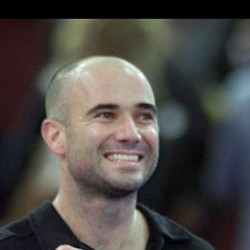

In [17]:
def recomender(vectors,names,path):
    mod = list(vectors)
    s_N = names
    s = pd.Series(s_N)
    s_vector = ([mod])
    df=pd.DataFrame(s)
    df['Vector']=mod
    df.columns=(['name','X'])
    test_person=load_dataset(path)
    test_person_pred=encodetor.predict(test_person)
    X_missing=test_person_pred
    df["diffs"] = df["X"].apply(lambda X: np.linalg.norm(X-X_missing))
    results = df.groupby("name").agg({'diffs':'min'}).sort_values(by='diffs')
    s = '/'
    #filename = re.findall("[\w\/\.\_\d]+",filename)
    filename = './data/'+s.join(results.index[0])
    image = Image.open('{}'.format(filename))
    return image
res = recomender(vectors,names,'./data/fotop/Alex/alex1.jpg')
res